### Import Library

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt # type: ignore
plt.rcParams['axes.unicode_minus'] = False
import numpy as np # type: ignore
import pandas as pd # type: ignore
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm # type: ignore
from factor_analyzer import FactorAnalyzer # type: ignore
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo # type: ignore
from graphviz import Digraph # type: ignore
from scipy.optimize import minimize # type: ignore
from scipy.stats import stats # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from semopy import Model, Optimizer, semplot # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, Dataset # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from tqdm import tqdm # type: ignore
from argparse import Namespace

### Data Directory

In [3]:
feature_path = "../../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../../data/nationwide_eng_V1.csv"

### Factor Model

In [4]:
df = pd.read_csv(feature_path)[1:4].T.dropna()
df.columns = df.iloc[0]
df = df.iloc[1:].astype(float)
data = pd.read_csv(region_feature_path)[:17].T.dropna()
data.columns = data.iloc[0]
data = data.iloc[1:].astype(float)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)

Bartlett's test p-value: 0.0
KMO test: 0.8411609718819952


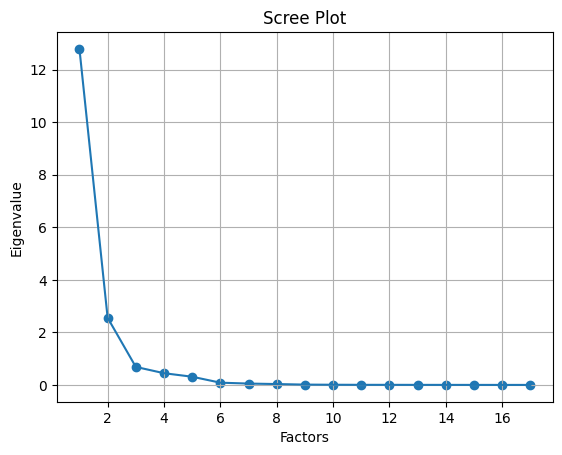

Optimal number of factors (Elbow Method): 1
Number of factors according to Kaiser Criterion: 2


In [6]:
# Conformity test for common factor analysis (Bartlett's sphericity test, KMO test)
chi_square_value, p_value = calculate_bartlett_sphericity(data_train)
kmo_all, kmo_model = calculate_kmo(data_train)

print("Bartlett's test p-value:", p_value)
print("KMO test:", kmo_model)

# Common factor analysis
# Run a scree test to determine the number of factors
fa = FactorAnalyzer(rotation=None, method='principal', n_factors=data_train.shape[1])
fa.fit(data_train)
ev, v = fa.get_eigenvalues()

# Eigenvalue graph
plt.scatter(range(1, data_train.shape[1]+1), ev)
plt.plot(range(1, data_train.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Select the point where 'elbow' appears in the above graph as the number of factors
# Calculate differences of eigenvalues
ev_diff = np.diff(ev)
# Find the point where the difference value is minimum (the 'elbow' point just before this point)
elbow_point = np.argmin(ev_diff) + 1  # Index Correction
print("Optimal number of factors (Elbow Method):", elbow_point)
# Calculate the number of factors with eigenvalues ​​greater than 1
n_factors_kaiser = (ev > 1).sum()
print("Number of factors according to Kaiser Criterion:", n_factors_kaiser)

Factor Loadings:
                                              0         1
Date                                                    
Seoul_apartment_sale_price_index      0.007446  1.006327
Busan_apartment_sale_price_index      0.719938  0.674877
Daegu_apartment_sale_price_index      0.598221  0.714891
Incheon_apartment_sale_price_index    0.150349  0.740936
Gwangju_apartment_sale_price_index    0.581617  0.774772
Daejeon_apartment_sale_price_index    0.539736  0.747848
Ulsan_apartment_sale_price_index      0.885696  0.417880
Sejong_apartment_sale_price_index     0.428811  0.727391
Gyeonggi_apartment_sale_price_index   0.126231  0.906564
Gangwon_apartment_sale_price_index    0.742842  0.612136
Chungbuk_apartment_sale_price_index   0.979413  0.197577
Chungnam_apartment_sale_price_index   0.966087  0.183671
Jeonbuk_apartment_sale_price_index    0.843762  0.399064
Jeonnam_apartment_sale_price_index    0.646887  0.704552
Gyeongbuk_apartment_sale_price_index  0.932989  0.194081
Gyeongnam_apa

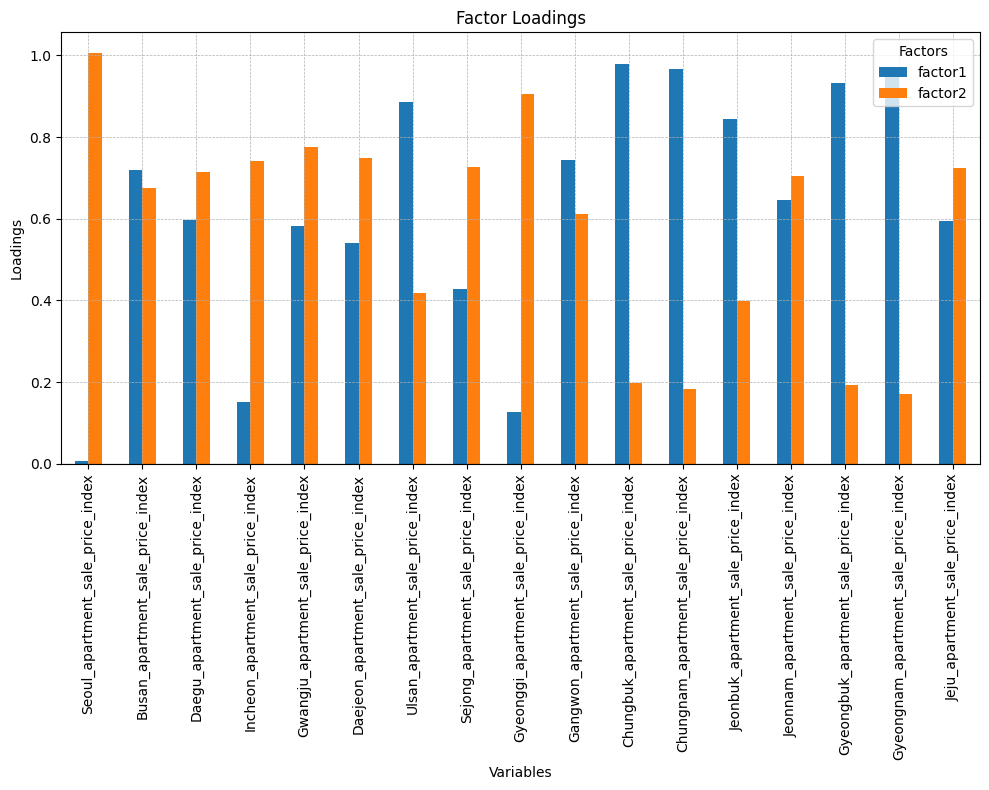

In [7]:
# Factor Analyze
fa = FactorAnalyzer(rotation='varimax', n_factors=2)
fa.fit(data_train)
loads = fa.loadings_
print("Factor Loadings:\n", pd.DataFrame(loads, index=data_train.columns))

variances = fa.get_factor_variance()
print("Factor Variances:", variances) 

loadings = pd.DataFrame(fa.loadings_, index=data_train.columns)
loadings.columns = ['factor1','factor2']

# Factor Loading Plot
fig, ax = plt.subplots(figsize=(10, 8))
loadings.plot(kind='bar', ax=ax)
ax.set_title('Factor Loadings')
ax.set_ylabel('Loadings')
ax.set_xlabel('Variables')
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Factors')
plt.tight_layout()
plt.show()

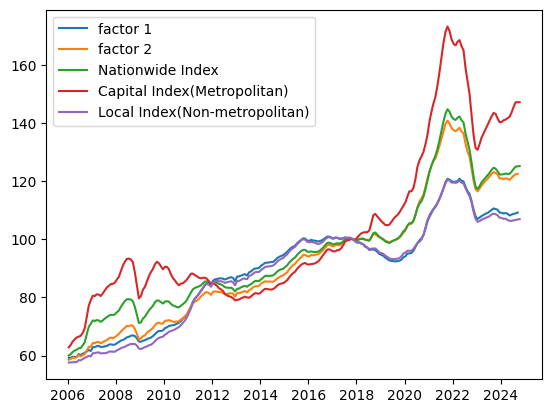

In [8]:
plt.plot(pd.to_datetime(data.index),(data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142],label="factor 1")
plt.plot(pd.to_datetime(data.index),(data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142],label="factor 2")
plt.plot(pd.to_datetime(df.index),df.iloc[:,0].values, label="Nationwide Index")
plt.plot(pd.to_datetime(df.index),df.iloc[:,1].values, label="Capital Index(Metropolitan)")
plt.plot(pd.to_datetime(df.index),df.iloc[:,2].values, label="Local Index(Non-metropolitan)")
plt.legend()
plt.show()

In [9]:
factor1 = (data * loadings['factor1']).sum(axis=1)*100/(data * loadings['factor1']).sum(axis=1)[142]
factor2 = (data * loadings['factor2']).sum(axis=1)*100/(data * loadings['factor2']).sum(axis=1)[142]

### Load Dataset for SEM

In [10]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

In [11]:
column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

In [12]:
df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
factor_df = pd.DataFrame([])
factor_df["factor1"] = factor1
factor_df["factor2"] = factor2
factor_df = factor_df.iloc[:-1,:]
factor_df = factor_df.dropna()
df = pd.concat([df,factor_df],axis=1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()
x_df = df[column]

# train : test = 8 : 2
X_train, X_test = train_test_split(x_df, test_size=0.2, shuffle=False)


### Granger Causality Test to define model spec of SEM

In [13]:
def adf_test(series, name=''):
    if series.isnull().any() or np.isinf(series).any():
        print(f"Error: {name} contains NaN or infinite values which must be cleaned before ADF test.")
        return False
    r = adfuller(series, autolag='AIC')
    p_value = r[1]
    print(f'ADF Statistic for {name}: {r[0]:.4f}')
    print(f'p-value for {name}: {p_value:.4f}')
    return p_value < 0.05

# Make Stationary
def process_series(series, name):
    print(f"\nProcessing {name}")
    if adf_test(series, name):
        print(f"{name} is already stationary.")
        return series
    
    # First Difference
    diff = series.diff().dropna()
    if diff.empty or not adf_test(diff, f'{name}_1st_diff'):
        # Second Difference
        diff2 = diff.diff().dropna()
        if diff2.empty or not adf_test(diff2, f'{name}_2nd_diff'):
            print(f"{name} is still non-stationary after all transformations.")
            return None
        else:
            print(f"{name}_2nd_diff is now stationary.")
            return diff2
    else:
        print(f"{name}_1st_diff is now stationary.")
        return diff

results = {}
for name, column in X_train.items():
    result = process_series(column, name)
    if result is not None:
        results[f"{name}"] = result 
        
stationary_df = pd.DataFrame(results)



Processing call_interest_rate
ADF Statistic for call_interest_rate: -1.5869
p-value for call_interest_rate: 0.4902
ADF Statistic for call_interest_rate_1st_diff: -5.9949
p-value for call_interest_rate_1st_diff: 0.0000
call_interest_rate_1st_diff is now stationary.

Processing government_bond_3yr
ADF Statistic for government_bond_3yr: -0.5966
p-value for government_bond_3yr: 0.8718
ADF Statistic for government_bond_3yr_1st_diff: -4.3003
p-value for government_bond_3yr_1st_diff: 0.0004
government_bond_3yr_1st_diff is now stationary.

Processing deposit_bank_loan_rate_avg
ADF Statistic for deposit_bank_loan_rate_avg: -0.6401
p-value for deposit_bank_loan_rate_avg: 0.8617
ADF Statistic for deposit_bank_loan_rate_avg_1st_diff: -8.2294
p-value for deposit_bank_loan_rate_avg_1st_diff: 0.0000
deposit_bank_loan_rate_avg_1st_diff is now stationary.

Processing KOSPI_index
ADF Statistic for KOSPI_index: -2.1641
p-value for KOSPI_index: 0.2195
ADF Statistic for KOSPI_index_1st_diff: -11.0249
p-va

In [14]:
stationary_df_dropna = stationary_df.dropna()
granger_value = {}
# 그레인저 인과성 테스트 함수 및 최소 p-value 래그 저장
def granger_test(data, target, maxlag=12):
    min_p_values = {}
    for col in data.columns:
        if col != target:
            test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag, verbose=False)
            min_p_value = float('inf')
            min_p_lag = 0
            for lag, result in test_result.items():
                p_value = result[0]['ssr_chi2test'][1]  # p-value
                if p_value < min_p_value:
                    min_p_value = p_value
                    min_p_lag = lag
            if min_p_value < 0.05:
                min_p_values[col] = min_p_lag # round(min_p_value,3))
    granger_value[target] = min_p_values
    return min_p_values

for col in X_train.columns:
    anw = granger_test(X_train, col, 23)

In [15]:
granger_value

{'call_interest_rate': {'government_bond_3yr': 11,
  'deposit_bank_loan_rate_avg': 23,
  'KOSPI_index': 1,
  'KOSDAQ_index': 1,
  'M2_Korea': 23,
  'M2_USA': 22,
  'broad_liquidity': 22,
  'CPI_growth_rate': 22,
  'USD_KRW_exchange_rate': 1,
  'real_GDP_growth_rate': 1,
  'residential_building_start_status': 20,
  'residential_building_permit_status': 23,
  'construction_production_index_seasonally_adjusted': 23},
 'government_bond_3yr': {'call_interest_rate': 16,
  'deposit_bank_loan_rate_avg': 15,
  'KOSPI_index': 20,
  'KOSDAQ_index': 4,
  'M2_Korea': 4,
  'M2_USA': 3,
  'broad_liquidity': 20,
  'USD_KRW_exchange_rate': 5,
  'real_GDP_growth_rate': 17,
  'residential_building_permit_status': 23,
  'construction_production_index_seasonally_adjusted': 22},
 'deposit_bank_loan_rate_avg': {'call_interest_rate': 11,
  'government_bond_3yr': 14,
  'KOSPI_index': 13,
  'KOSDAQ_index': 1,
  'M2_Korea': 23,
  'M2_USA': 2,
  'broad_liquidity': 20,
  'USD_KRW_exchange_rate': 5,
  'real_GDP_gro

In [16]:
print("interest_rate")
print(set.intersection(
                set(granger_value['call_interest_rate'].keys()),
                set(granger_value['government_bond_3yr'].keys()),
                set(granger_value['deposit_bank_loan_rate_avg'].keys())))
print("-----------")
print("stock")
print(set.intersection(
                set(granger_value['KOSPI_index'].keys()),
                set(granger_value['KOSDAQ_index'].keys()),
                set(granger_value['NASDAQ_index'].keys())))
print("-----------")
print("money_supply")
print(set.intersection(
                set(granger_value["M2_Korea"].keys()),
                set(granger_value["M2_USA"].keys())))
print("-----------")
print("construction")
print(set.intersection(
                set(granger_value["residential_building_start_status"].keys()),
                set(granger_value["residential_building_permit_status"].keys())))



interest_rate
{'USD_KRW_exchange_rate', 'M2_USA', 'residential_building_permit_status', 'broad_liquidity', 'construction_production_index_seasonally_adjusted', 'real_GDP_growth_rate', 'M2_Korea', 'KOSDAQ_index', 'KOSPI_index'}
-----------
stock
{'USD_KRW_exchange_rate', 'government_bond_3yr', 'CPI_growth_rate', 'M2_USA', 'broad_liquidity', 'deposit_bank_loan_rate_avg', 'real_GDP_growth_rate', 'M2_Korea', 'call_interest_rate'}
-----------
money_supply
{'USD_KRW_exchange_rate', 'government_bond_3yr', 'NASDAQ_index', 'construction_production_index_seasonally_adjusted', 'real_GDP_growth_rate', 'KOSDAQ_index', 'call_interest_rate', 'KOSPI_index'}
-----------
construction
{'government_bond_3yr', 'CPI_growth_rate', 'deposit_bank_loan_rate_avg', 'M2_Korea', 'KOSDAQ_index', 'call_interest_rate', 'KOSPI_index'}


In [17]:
# Define the SEM model specification in semopy syntax
mod_spec = f"""
    # Measurement model
    interest_rate =~ call_interest_rate + government_bond_3yr + deposit_bank_loan_rate_avg
    stock =~ KOSPI_index + KOSDAQ_index + NASDAQ_index
    money_supply =~ M2_Korea + M2_USA
    liquidity =~ broad_liquidity
    inflation =~ CPI_growth_rate
    exchange_rate =~ USD_KRW_exchange_rate
    gdp =~ real_GDP_growth_rate
    construction =~ residential_building_start_status + residential_building_permit_status
    construction_production =~ construction_production_index_seasonally_adjusted

    # Structural model
    interest_rate ~ gdp + liquidity + construction_production + money_supply + exchange_rate
    stock ~ liquidity + interest_rate + gdp + money_supply + inflation + exchange_rate
    money_supply ~ gdp + exchange_rate + stock + construction_production
    liquidity ~ interest_rate + money_supply + inflation + exchange_rate + gdp
    inflation ~ interest_rate + stock + liquidity + exchange_rate + gdp + construction_production
    exchange_rate ~ money_supply + liquidity + gdp
    gdp ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + construction_production
    construction ~ interest_rate + inflation
    construction_production ~ interest_rate + stock + liquidity + inflation + exchange_rate + gdp + construction
"""
spec = mod_spec + """
    factor ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + \
            gdp +\
            construction + construction_production # + housing_construction
    """

### SEM

In [18]:
def z_transform(X, mu, std):
    """
    ==========================
    | X: df, mu: df, std: df |
    ==========================
    """
    return (X-mu)/(std+0.000001)

def inv_z_transform(y, mu, std):
    """
    ====================================
    | y: ndarray, mu: df, std: df      |
    ====================================
    """
    return y * (std+0.000001) + mu

In [19]:
lag = 3 # 3-month ahead

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production
    
df = df[column]
df = df.shift(lag) # predict the future by taking past data of explanatory variables
df = df.dropna()
factor_df = pd.DataFrame([])
factor_df["factor1"] = factor1
factor_df["factor2"] = factor2
factor_df = factor_df.iloc[:-1,:]
factor_df = factor_df.dropna()
df = pd.concat([df,factor_df],axis=1) 
df = df[18:]
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [20]:
# target = "factor1"
def train_sem(target_value): 
    x_df = df[column]
    y_df = df[target_value]

    # train : valid : test = 6 : 2 : 2
    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.4, shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_valid = z_transform(X_valid, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_valid = z_transform(y_valid, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    df_train_inv = pd.concat([pd.DataFrame(y_train), X_train], axis=1)
    df_valid_inv = pd.concat([pd.DataFrame(y_valid), X_valid], axis=1)
    df_test_inv = pd.concat([pd.DataFrame(y_test), X_test], axis=1)
    
    # Instantiate and fit the model
    spec = mod_spec + f"""
    {target_value} ~ interest_rate + stock + money_supply + liquidity + inflation + exchange_rate + \
            gdp +\
            construction + construction_production # + housing_construction
    """
    model = Model(spec)

    optimization_methods = ['MLW', 'ULS', 'GLS', 'WLS', 'DWLS', 'FIML']
    best_method = ''
    lowest_rmse = float('inf')

    for method in optimization_methods:
        model = Model(spec)
        try:
            model.fit(data=df_train_inv, obj=method)
            estimates = model.inspect()
            y_pred_valid = model.predict(df_valid_inv.drop(target_value, axis=1))[target_value]
            mse = mean_squared_error(df_valid_inv[target_value], y_pred_valid)
            if mse < lowest_rmse:
                lowest_rmse = mse
                best_method = method

        except Exception as e:
            # 오류가 발생했을 때 실행될 코드
            print(f"An error occurred: {e} in {method}")
        continue

    print(f"Best optimization method: {best_method} with MSE: {lowest_rmse:.4f}")
    model = Model(spec)
    opt_res = model.fit(data = df_train_inv,
                        obj = best_method)
                                    # "MLW" (the default): Wishart loglikelihood;
                                    # "ULS": Unweighted Least Squares;
                                    # "GLS": Generalized Least Squares;
                                    # "WLS": Weighted Least Squares (also known as an Asymptotic Distribution-Free Estimator);
                                    # "DWLS": Diagonally Weighted Least Squares (also known as robust WLS);
                                    # "FIML": Full Information Maximum Likelihood (when data has no missing values FIML is effectively a Multivariate Normal Maximum Likelihood).
    estimates = model.inspect()
    

    y_pred_train = model.predict(df_train_inv.drop(target_value, axis=1))[target_value]
    y_pred_valid = model.predict(df_valid_inv.drop(target_value, axis=1))
    y_pred = model.predict(df_test_inv.drop(target_value, axis=1))
    results_df = pd.DataFrame({
        'Actual': df_test_inv[target_value],
        'Predicted': y_pred[target_value]
    })

    # accuracy assessment
    results_df = results_df.dropna()
    mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_train_inv.index),y_train,c="b")
    plt.plot(pd.to_datetime(df_train_inv.index),y_pred_train,c="r")
    plt.plot(pd.to_datetime(df_valid_inv.index), df_valid_inv[target_value], c="b")
    plt.plot(pd.to_datetime(df_valid_inv.index), y_pred_valid[target_value],c="r")
    plt.plot(pd.to_datetime(df_test_inv.index), df_test_inv[target_value], label='Actual',c="b")
    plt.plot(pd.to_datetime(df_test_inv.index), y_pred[target_value], label='Predicted',c="r")
    plt.axvline(x=pd.to_datetime(y_valid.index[0]), color='black', linestyle=':', linewidth=3)
    plt.axvline(x=pd.to_datetime(y_test.index[0]), color='black', linestyle=':', linewidth=3)
    plt.title('Actual vs Predicted Factor')
    plt.xlabel('Observations')
    plt.ylabel('Factor')
    plt.legend()
    plt.show()
    
    return pd.concat([inv_z_transform(y_pred_train, y_df_mu, y_df_std),
                      inv_z_transform(y_pred_valid[target_value], y_df_mu, y_df_std),
                      inv_z_transform(y_pred[target_value], y_df_mu, y_df_std)])

In [21]:
# Initialize Digraph from graphviz
dot = Digraph(comment='SEM Model')

# Parse model spec and create nodes and edges
lines = spec.split("\n")
for line in lines:
    line = line.strip()
    if line.endswith('=~'):
        continue
    if '=~' in line:
        latent, indicators = line.split('=~')
        latent = latent.strip()
        indicators = [ind.strip() for ind in indicators.split('+')]
        dot.node(latent, latent, shape='ellipse', color='lightblue')
        for indicator in indicators:
            dot.node(indicator, indicator, shape='box')
            dot.edge(latent, indicator, dir='none')
    elif '~' in line:
        outcome, predictors = line.split('~')
        outcome = outcome.strip()
        predictors = [pred.strip() for pred in predictors.split('+')]
        for predictor in predictors:
            if predictor:
                dot.edge(predictor, outcome)

# Render the graph
output_path = 'sem_model'
dot.render(output_path, format='png', view=True)


'sem_model.png'

Best optimization method: WLS with MSE: 0.0667
Mean Squared Error (MSE): 0.3476
R-squared (R²): -2.0594


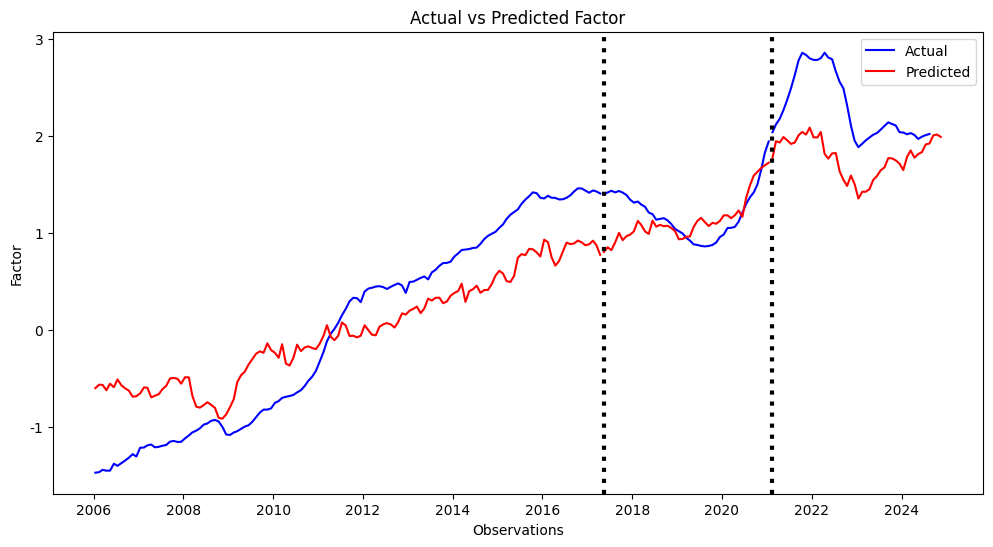

In [22]:
factor1_df = train_sem("factor1")

Best optimization method: FIML with MSE: 0.1077


Mean Squared Error (MSE): 0.3900
R-squared (R²): 0.1478


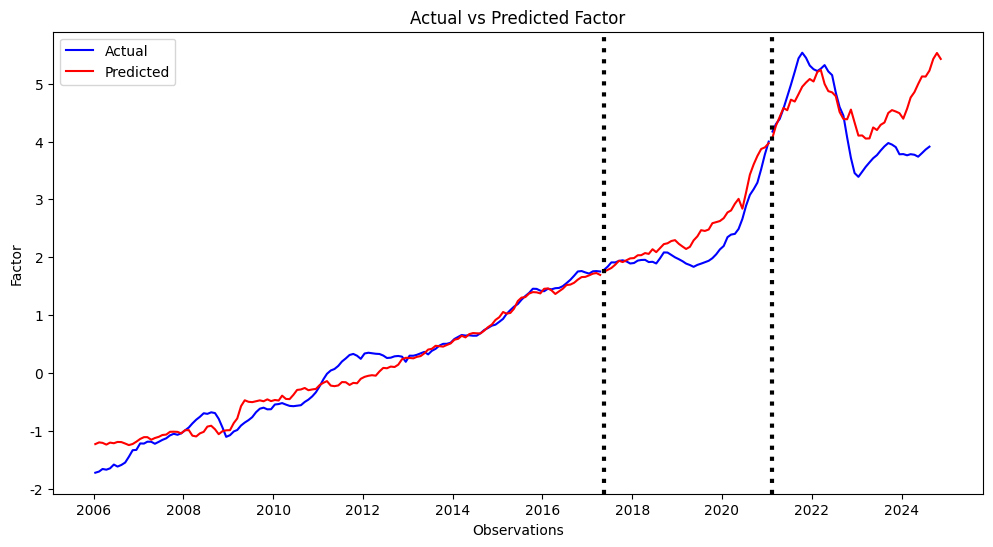

In [23]:
factor2_df = train_sem("factor2")

Target = Common Factor + Individual

In [24]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

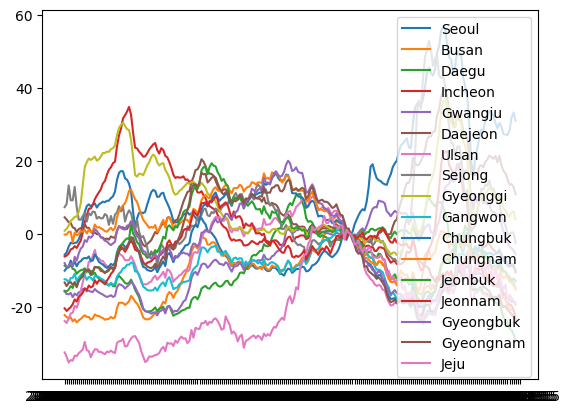

In [25]:
resid = pd.DataFrame([])
for i in range(len(fa.loadings_)):
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = data.iloc[:,i] - f*100/f[142]
    resid[target_column[i]] = f 
    plt.plot(f,label = target_column[i])
plt.legend()
plt.show()
    

### Load DataSet(with Resid) for Dlinear

In [30]:
column = ["call_interest_rate", "real_GDP_growth_rate","residential_building_start_status"]

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,resid], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

### Dlinear

In [ ]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs.seq_len # window_size
        self.pred_len = configs.pred_len # forcast_size

        # Decompsition Kernel Size
        kernel_size = configs.ker_len
        self.decompsition = series_decomp(kernel_size) # kernel_size
        self.individual = configs.individual # False
        self.channels = configs.enc_in # feature_size

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df(df, window_size, forecast_size, date, target, columns):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        if window_size > 0:
            # x: features from the past window_size (including columns)
            x = df_.loc[idx:idx+window_size-1, columns].values # Convert to a multidimensional array.
        else:
            # if you already use past variables, you may not need window_size
            # x: Use only the current time point
            x = df_.iloc[idx][columns].values.reshape(1, -1)
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def predict(model, data_loader, data_date, std, mean):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    dates = []
    with torch.no_grad():  # No need to track the gradients
        for data, target, date in zip(data_loader.dataset.X, data_loader.dataset.Y, data_date):
            data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # Add Batch dimension
            output = model(data).cpu().numpy().flatten()
            predictions.append(output)
            targets.append(torch.tensor(target, dtype=torch.float32).numpy().flatten())
            dates.append(date)  # save date
    
    # inverse transform(standardization)
    predictions = np.array(predictions).flatten() * std + mean
    targets = np.array(targets).flatten() * std + mean
    
    dates = np.array(dates).flatten()
    # Remove Duplicate Dates
    unique_dates, indices = np.unique(dates, return_index=True)
    predictions = np.array(predictions).flatten()[indices]
    targets = np.array(targets).flatten()[indices]
    
    return unique_dates, predictions, targets

### Common Experiment Setting

In [76]:
batch_size = 16
kernel_size = 25 

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [88]:
### Experiment Setting
version = "V1"
window_size = 3
forecast_size= 3 
epoch = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", 
                  "residential_building_start_status"] + [resid.columns[0]] # exampel: Column defined before & Target
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=True,
    enc_in= len(columns_to_use) # feature_size
)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

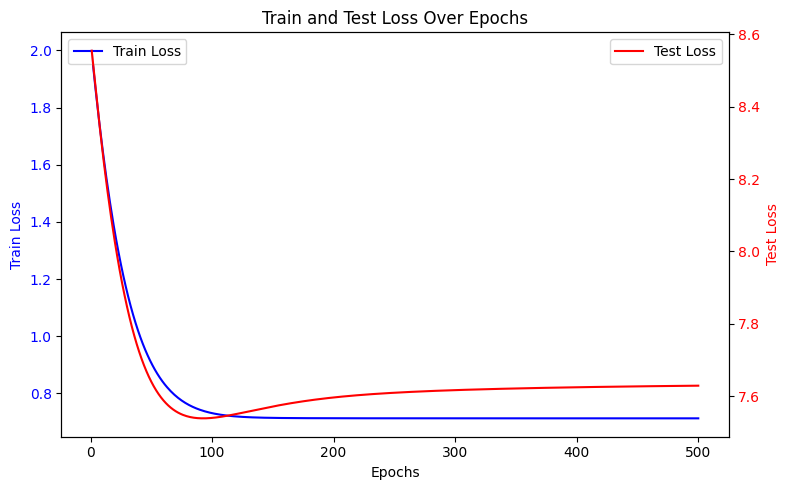

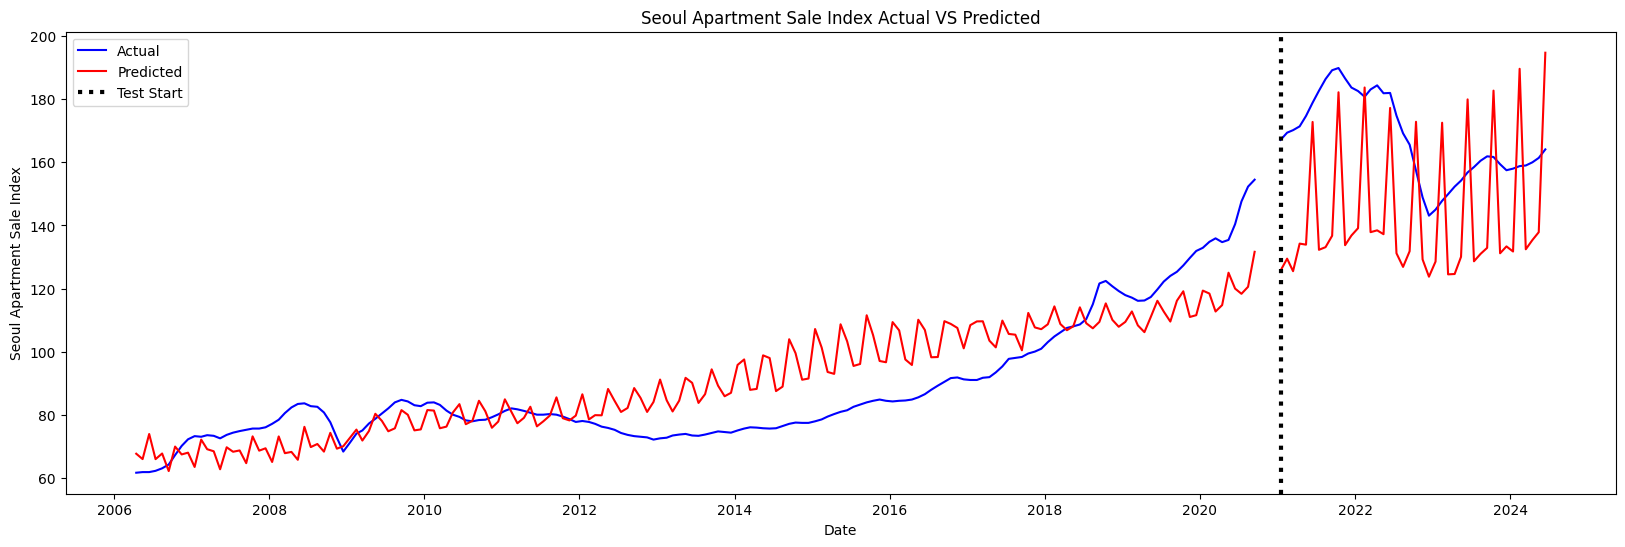

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

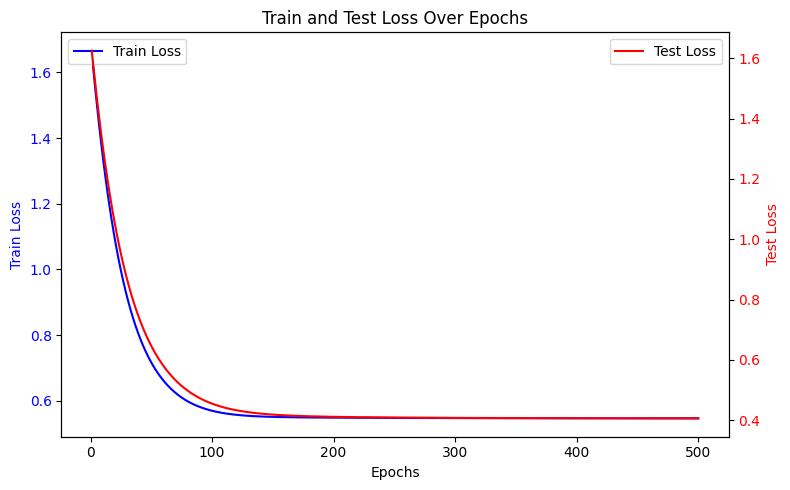

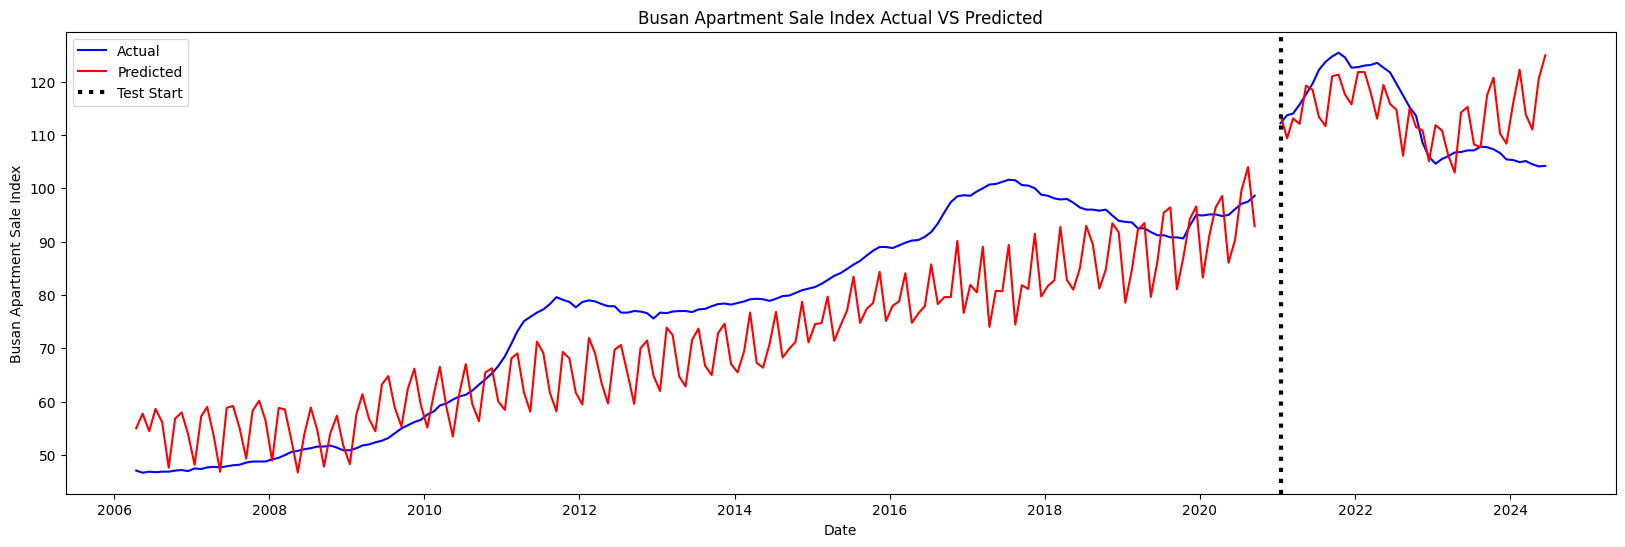

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

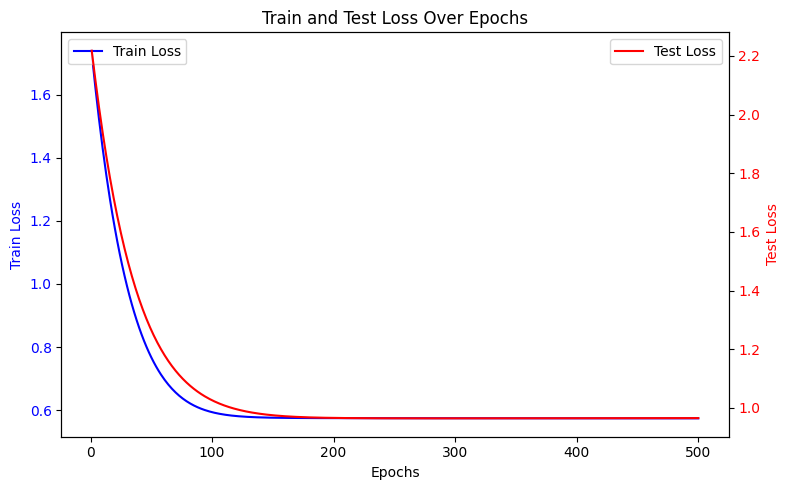

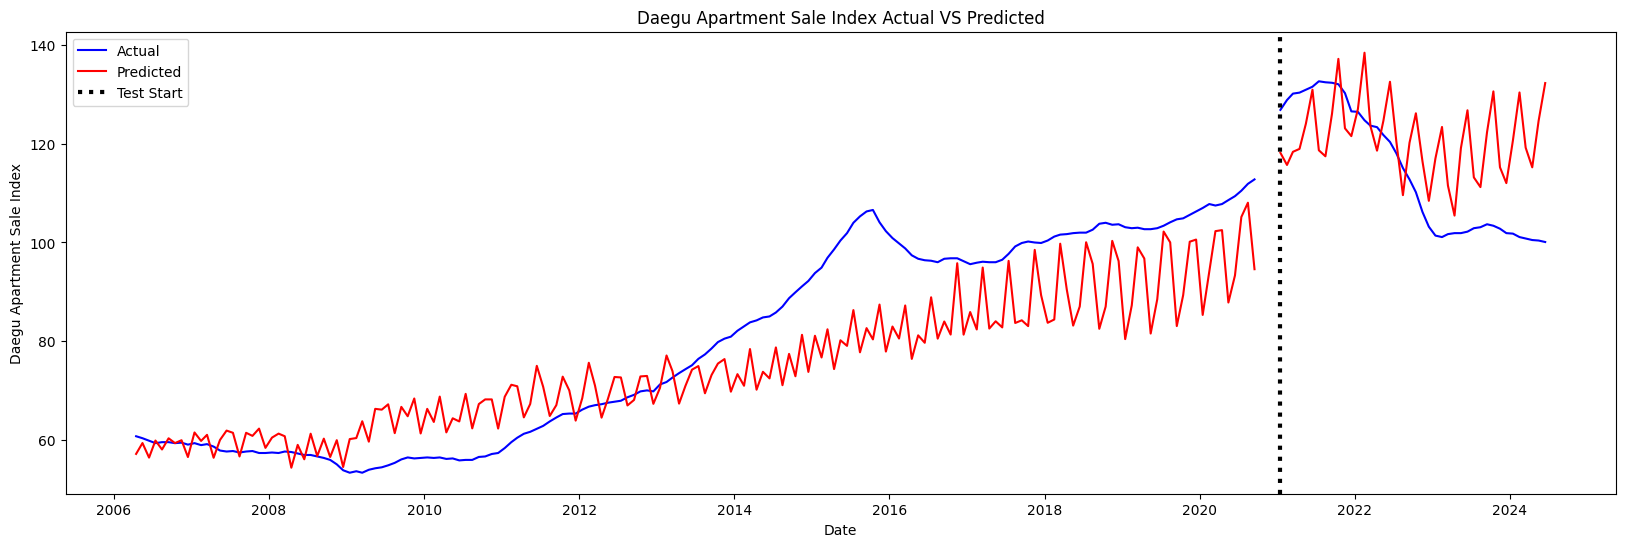

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

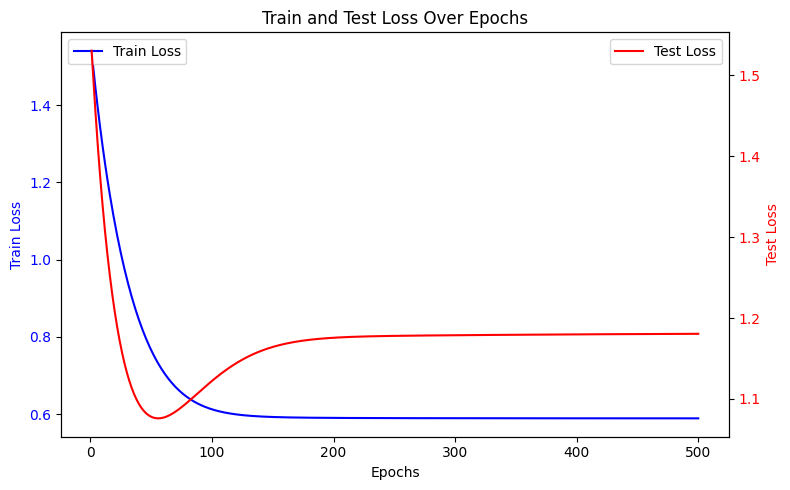

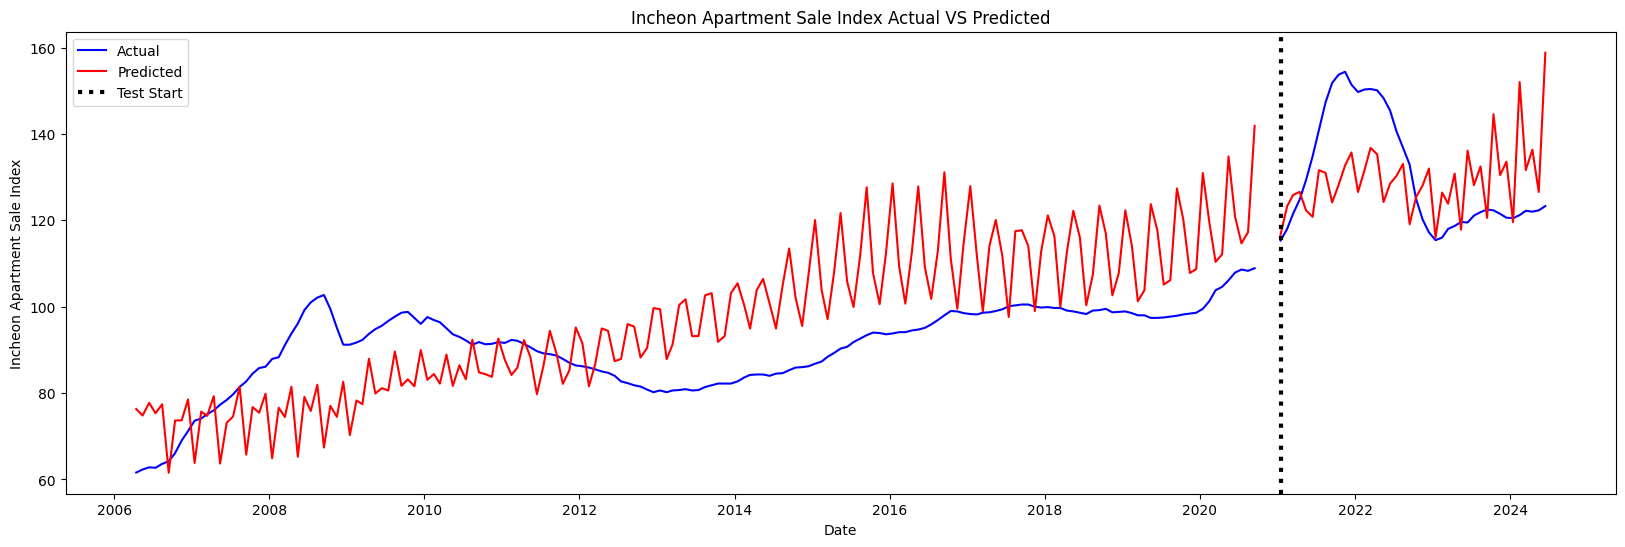

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

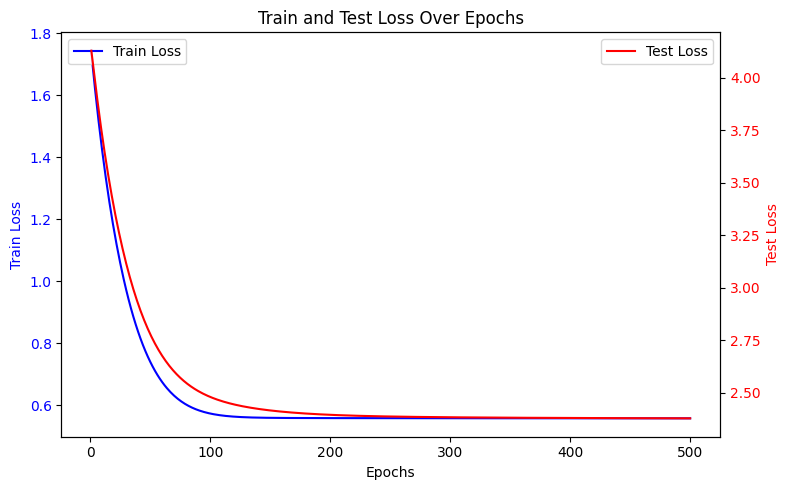

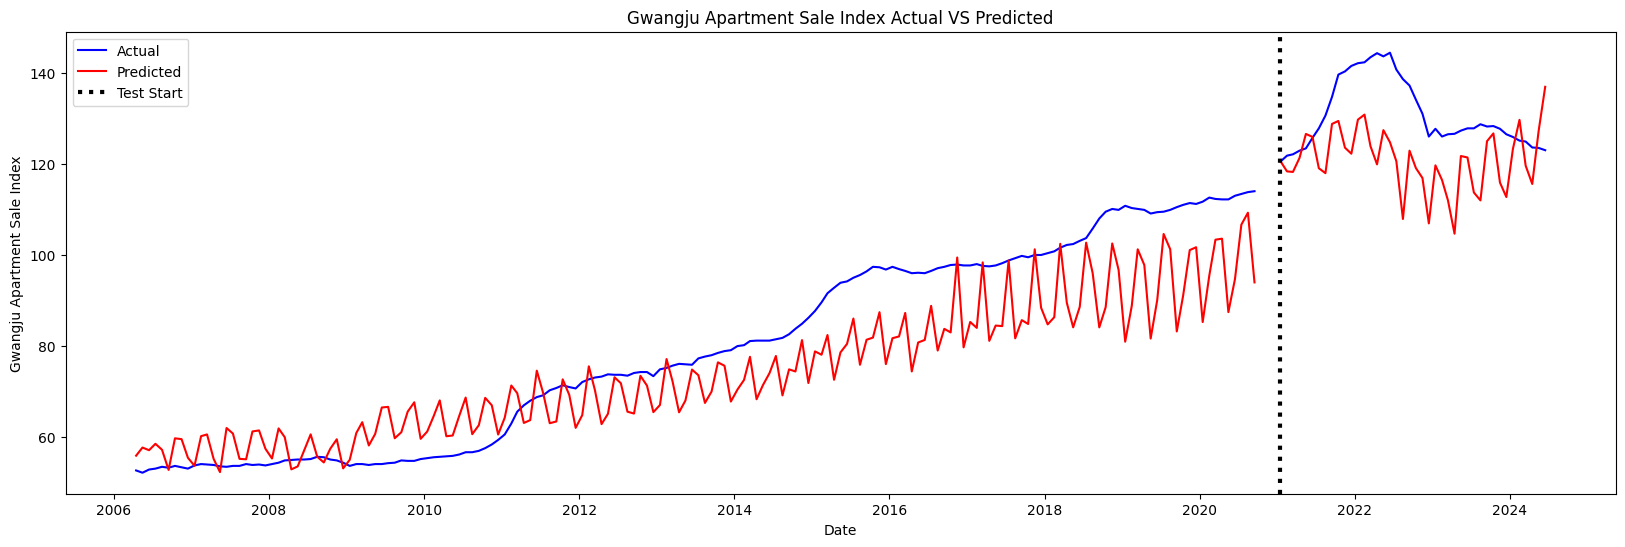

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

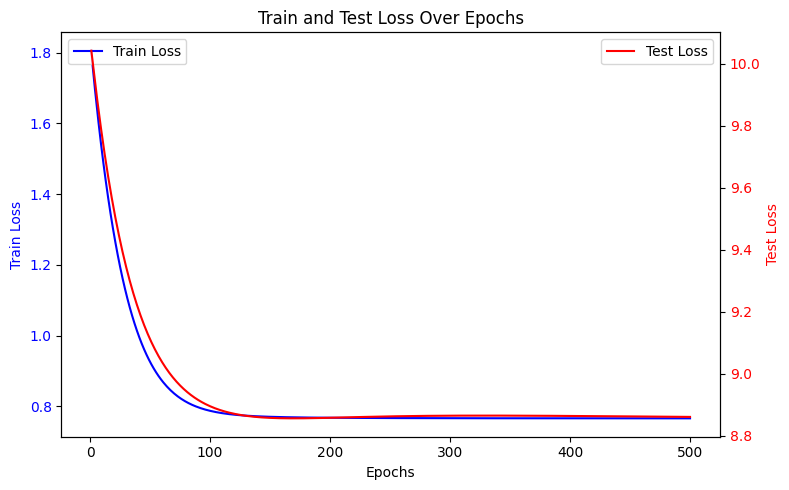

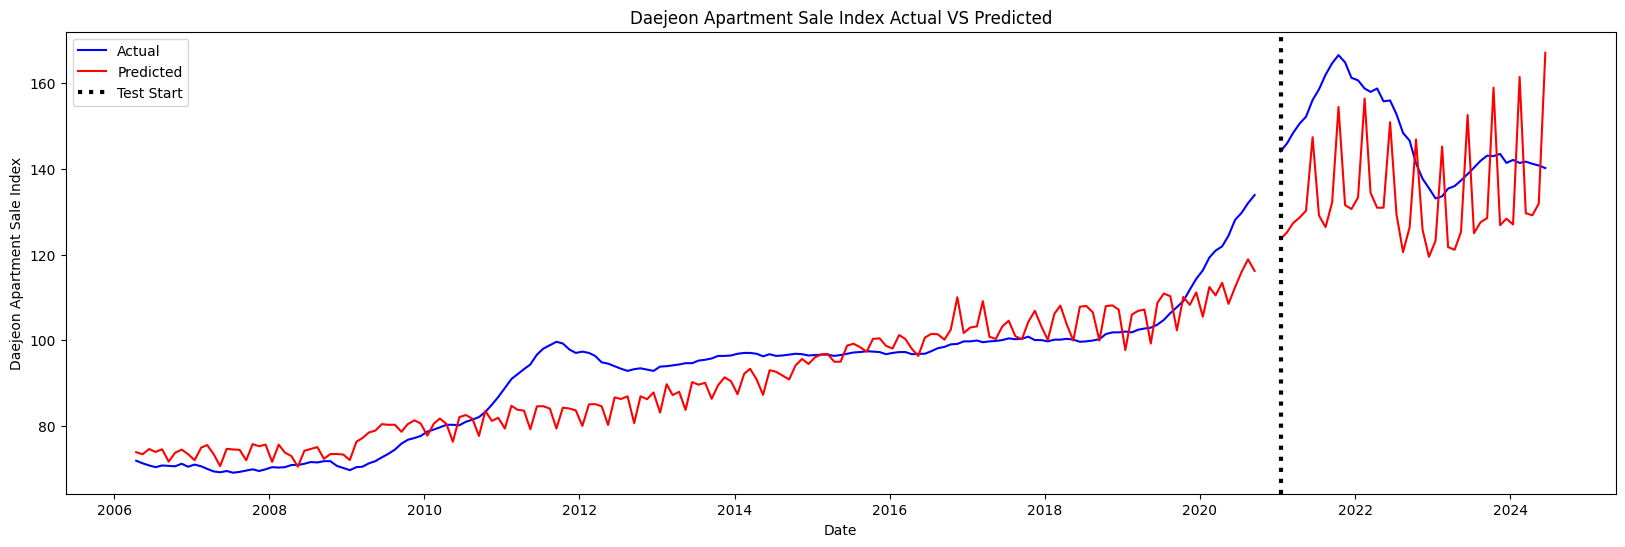

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

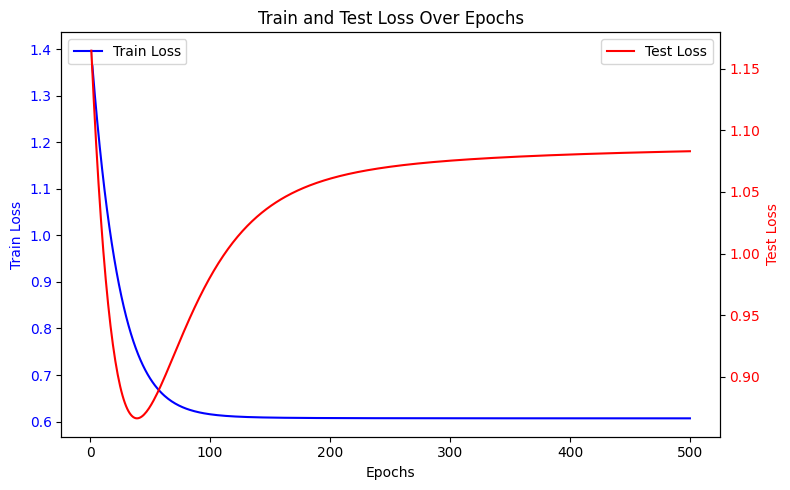

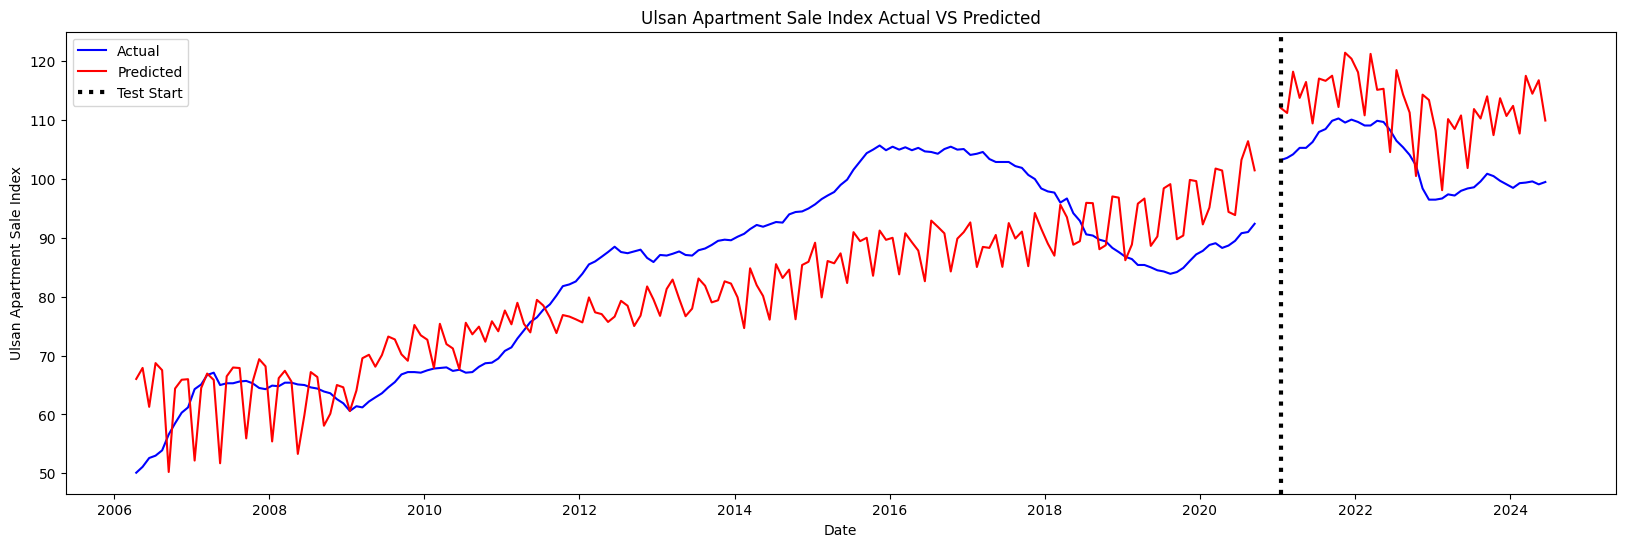

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

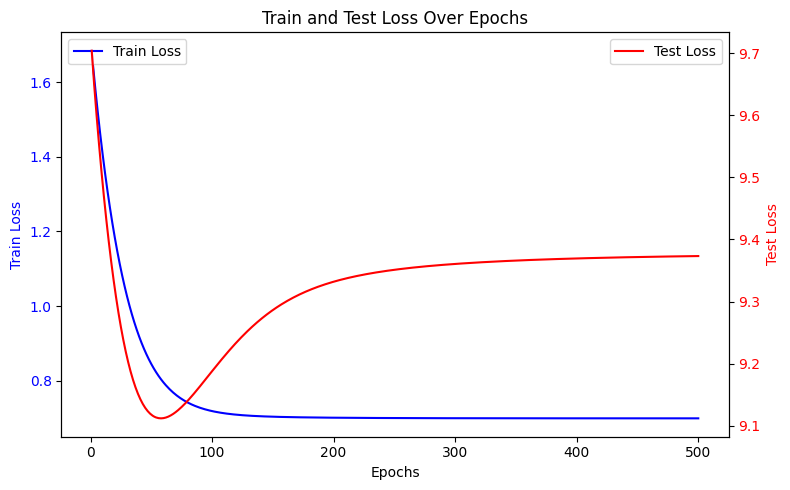

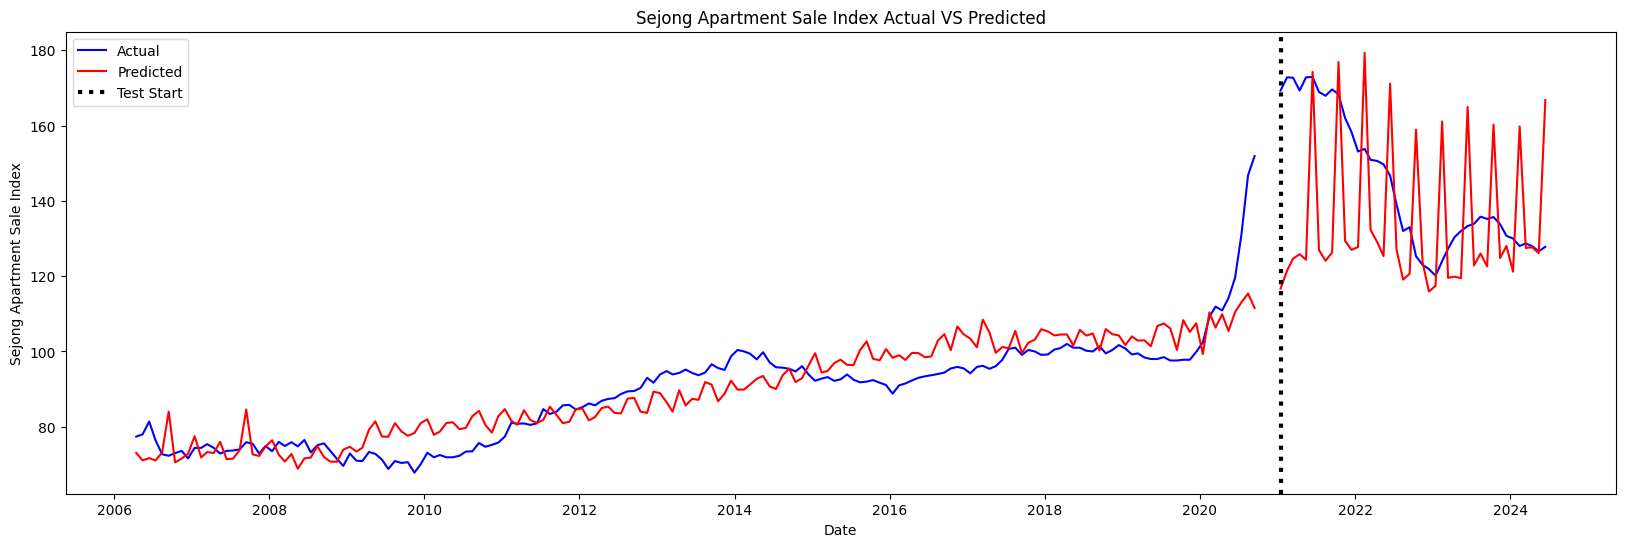

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

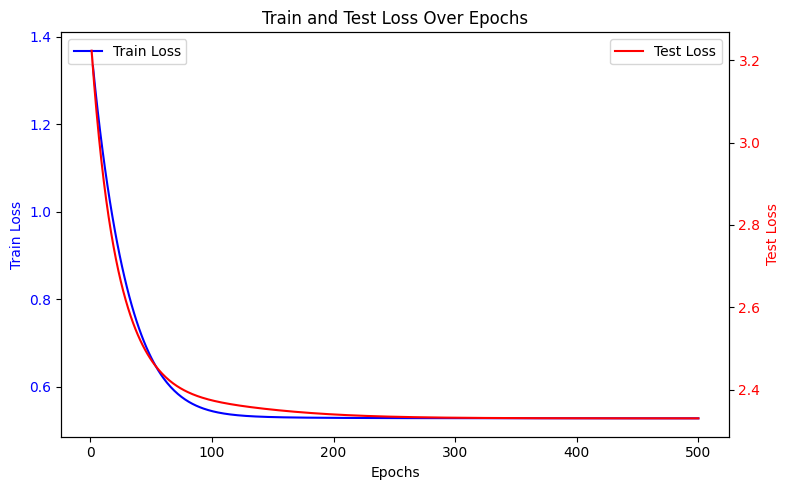

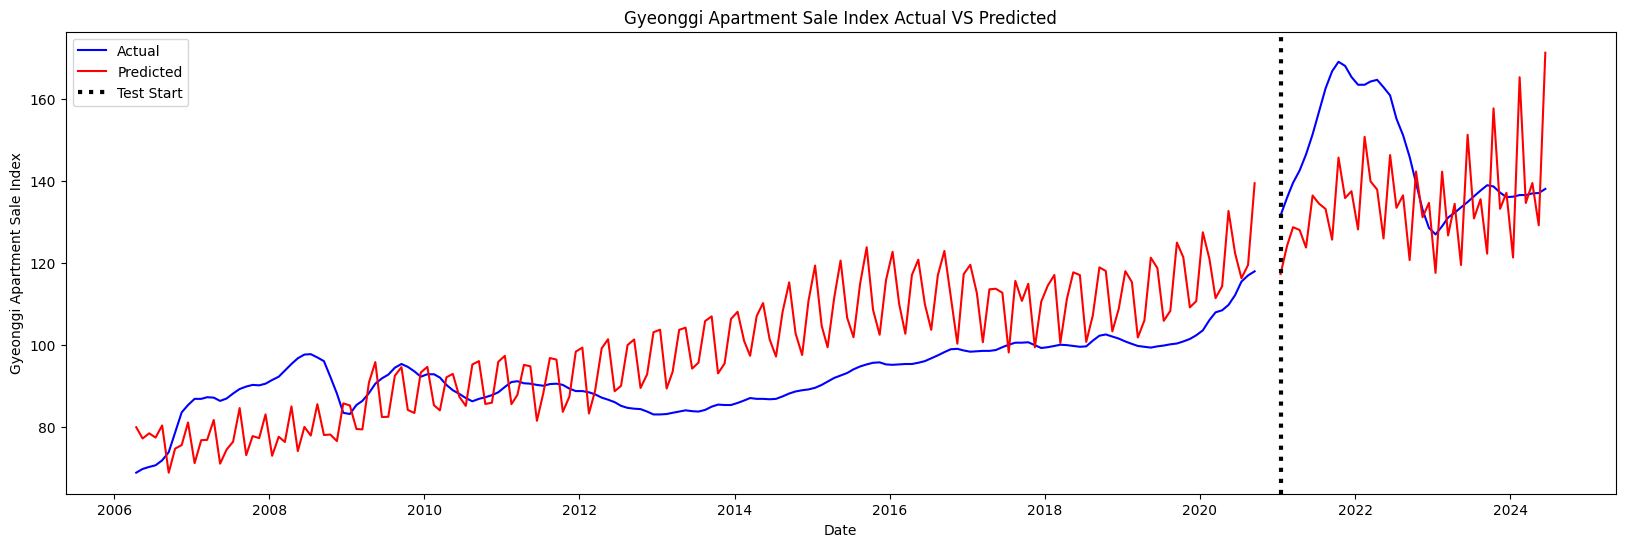

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

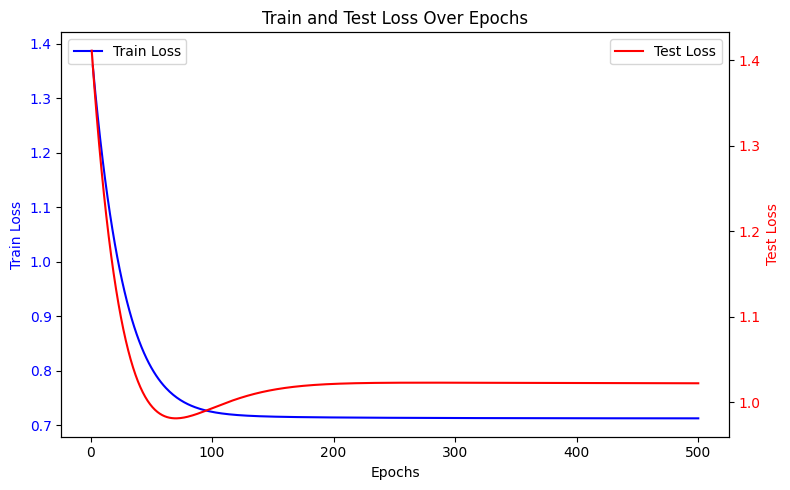

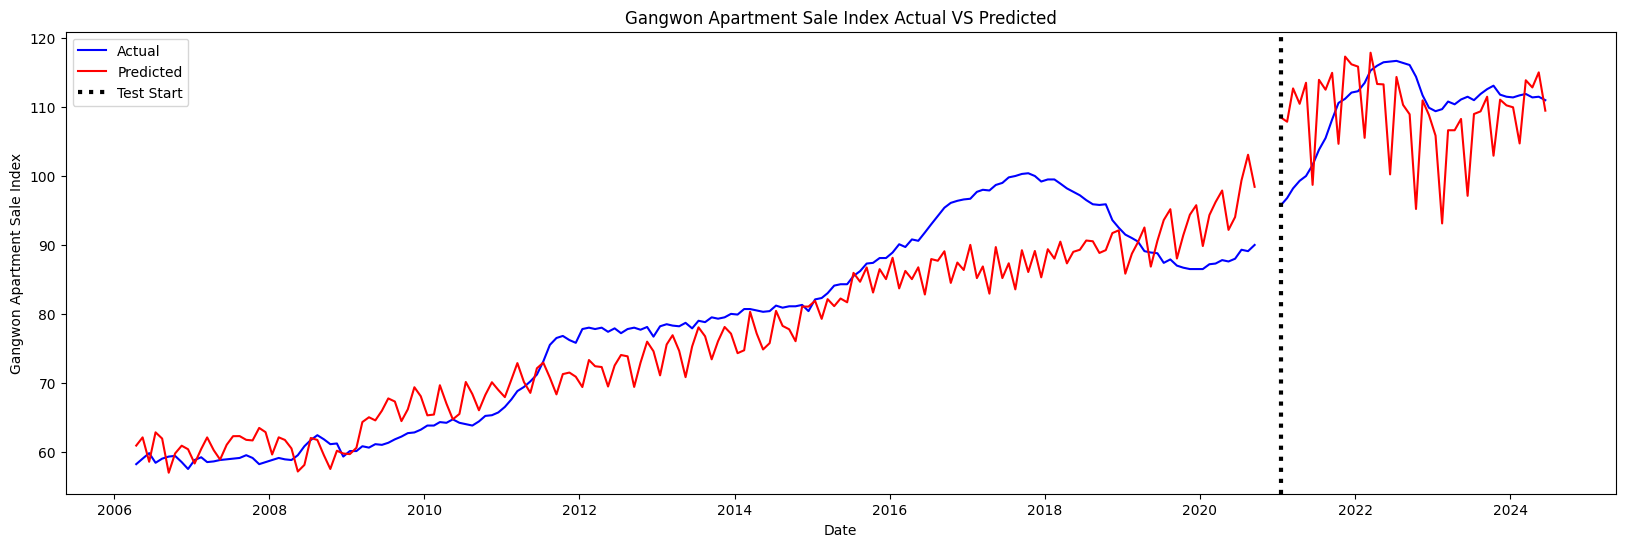

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

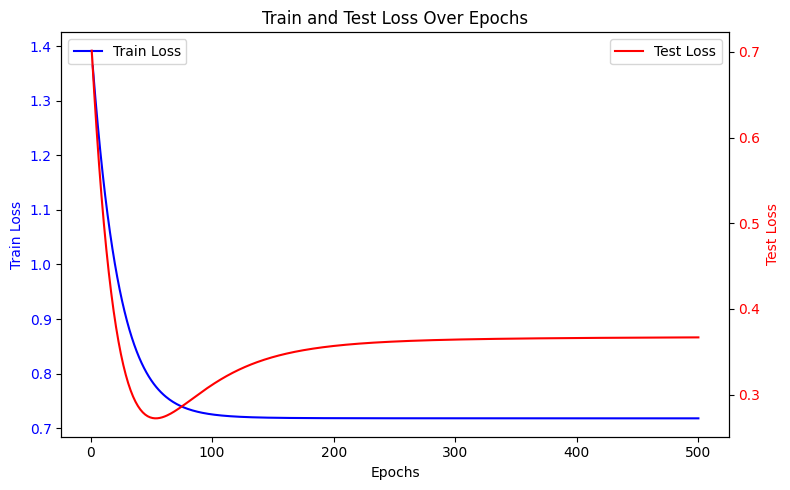

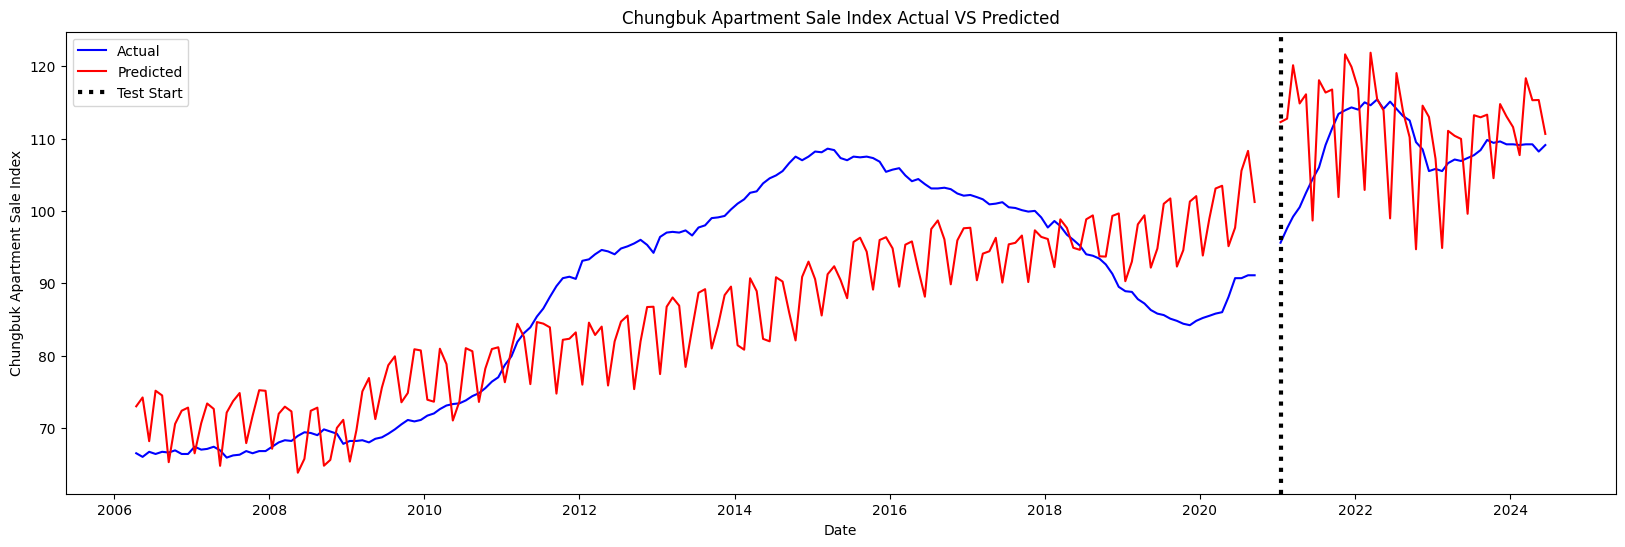

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

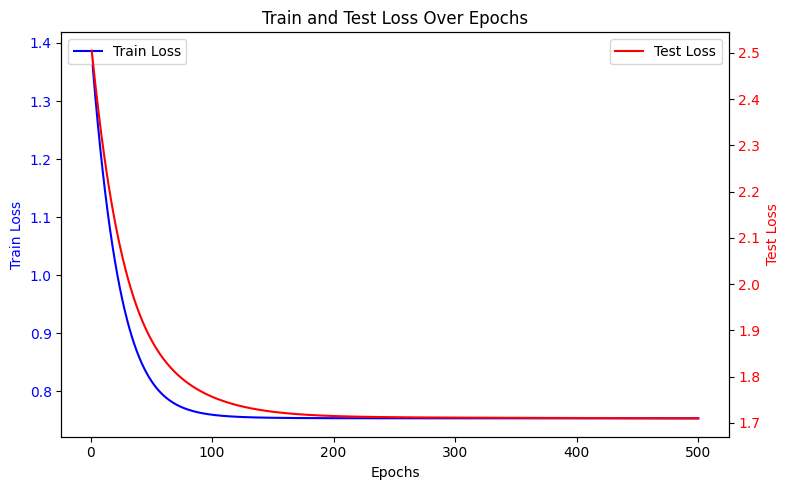

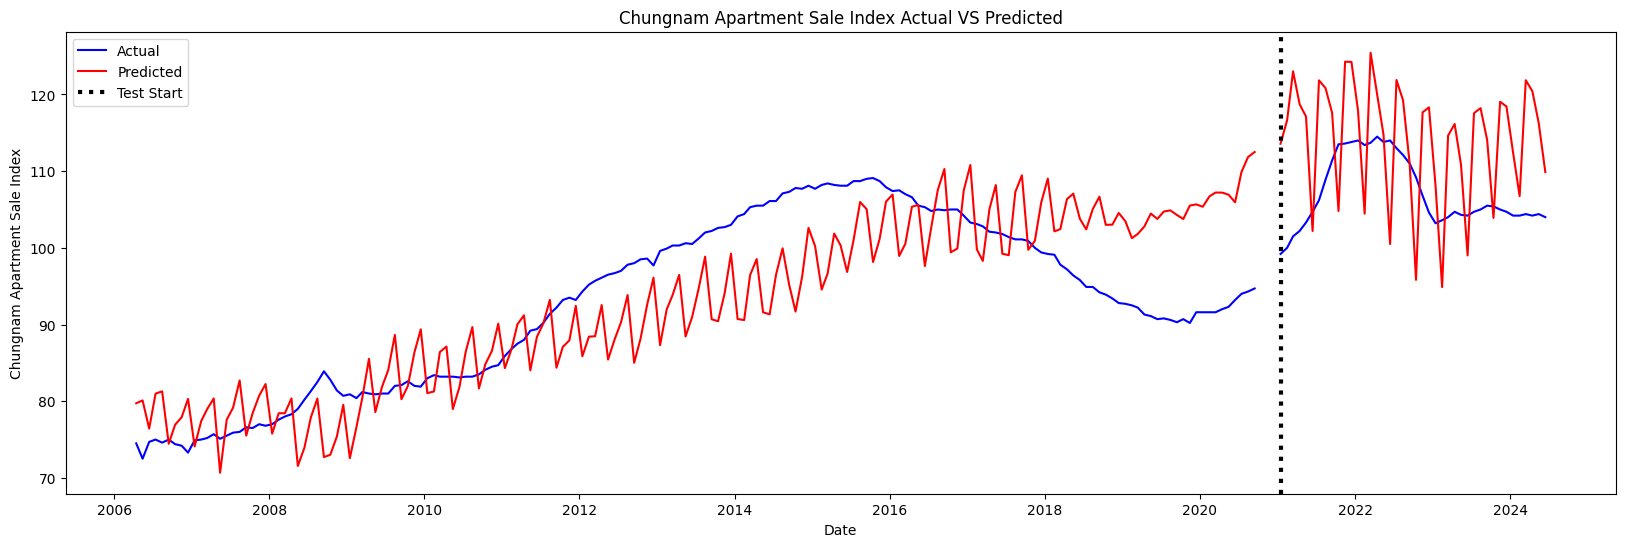

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

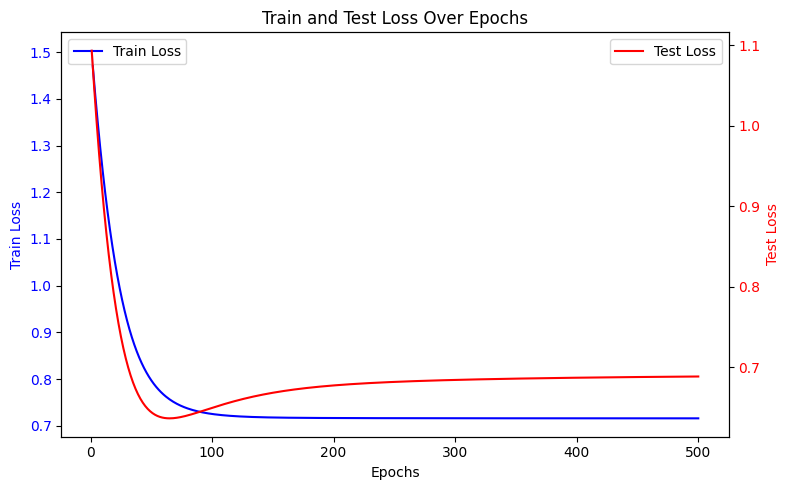

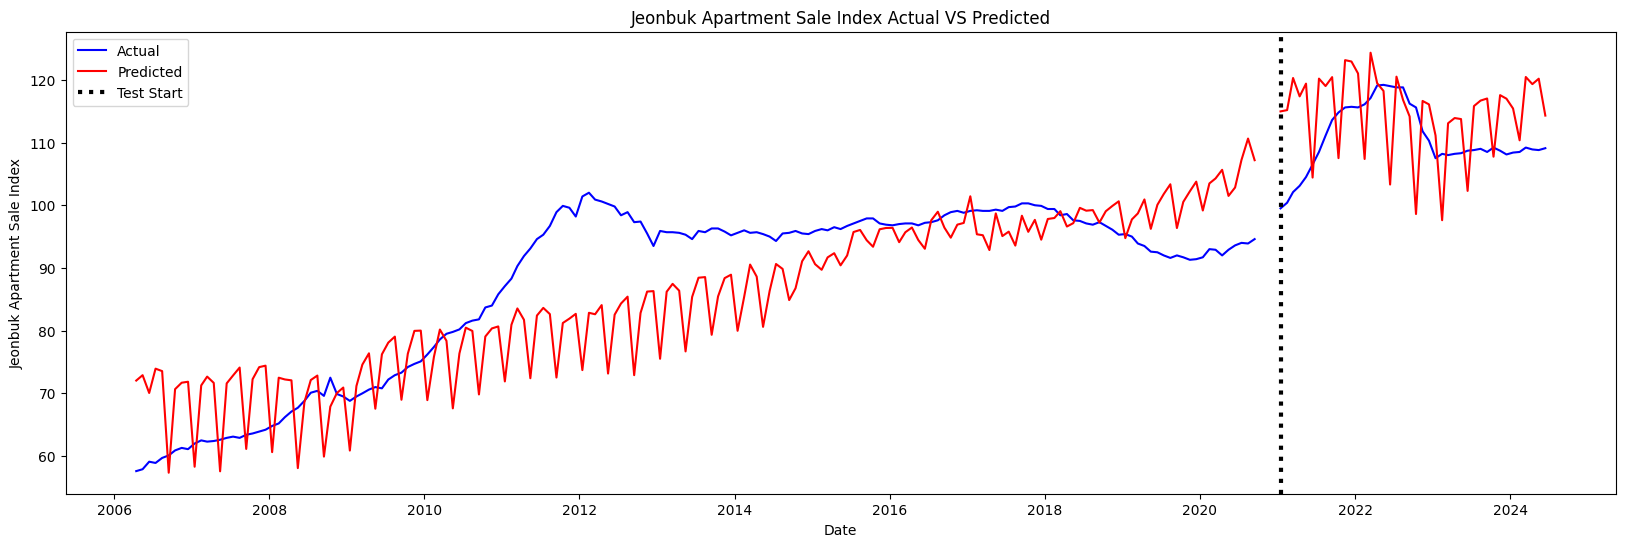

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

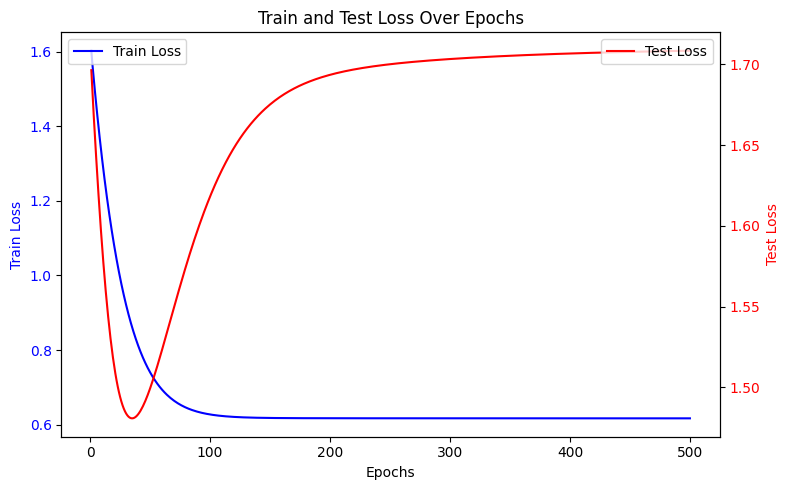

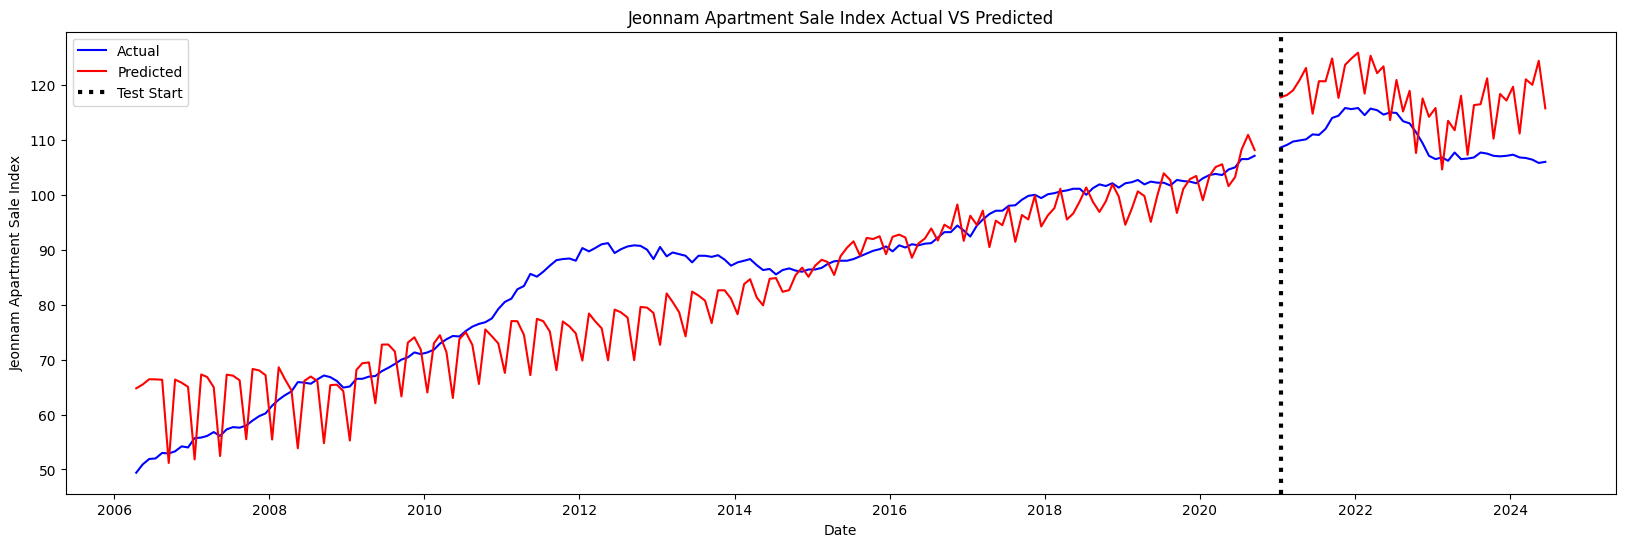

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

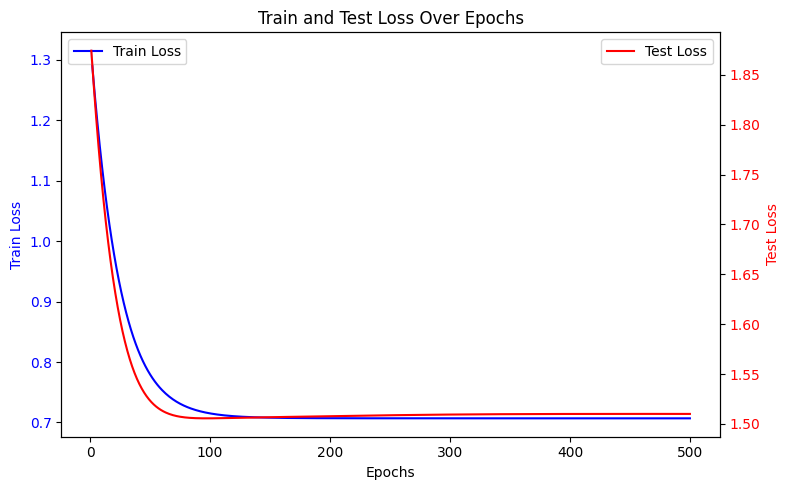

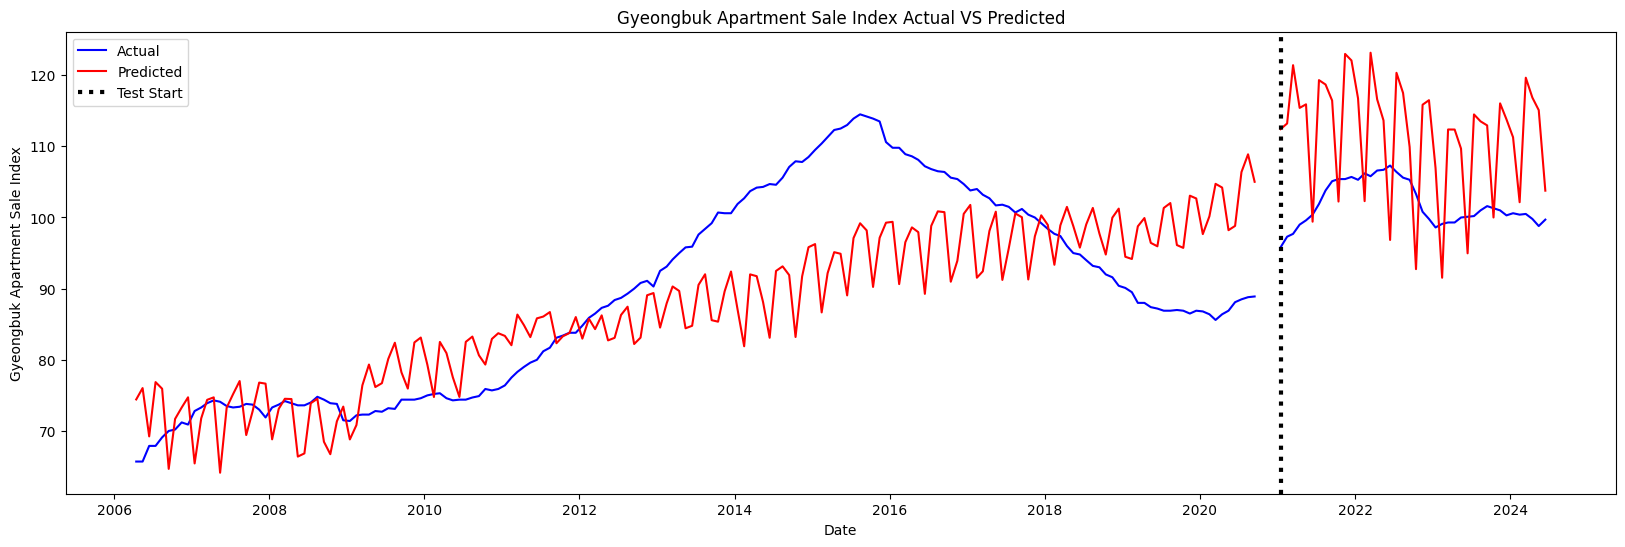

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

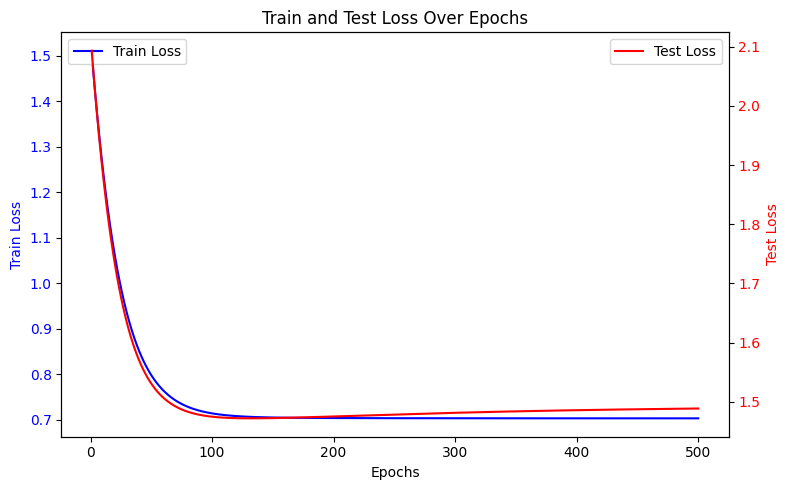

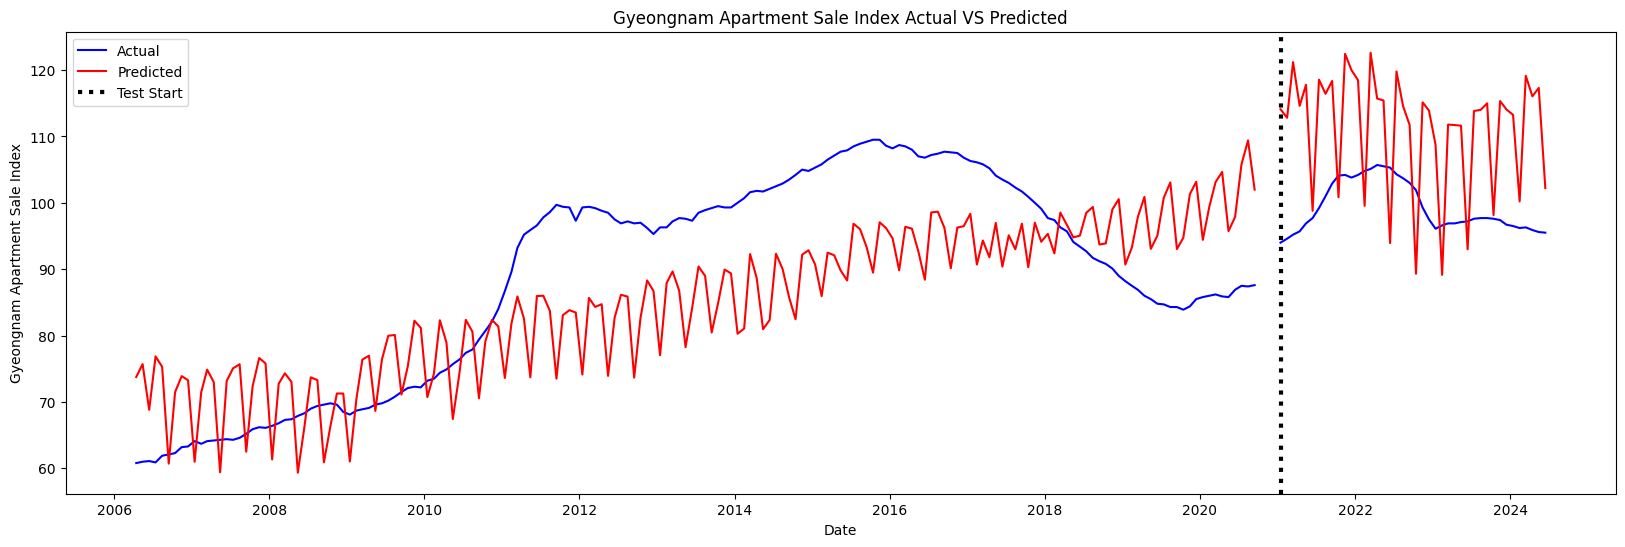

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

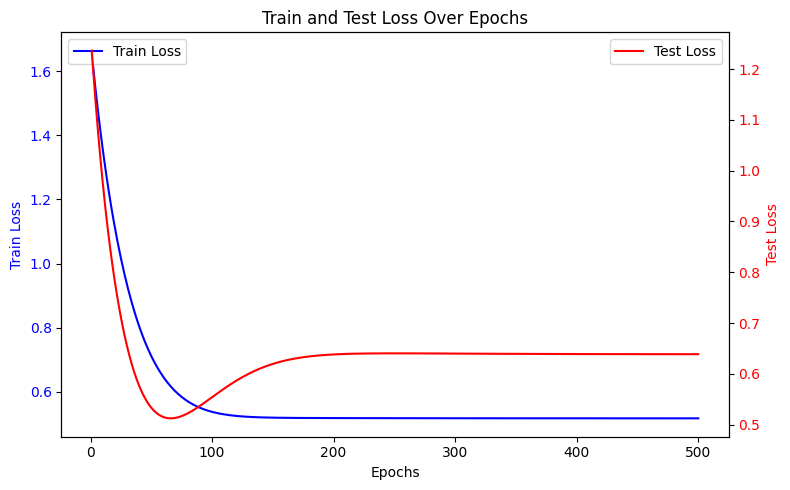

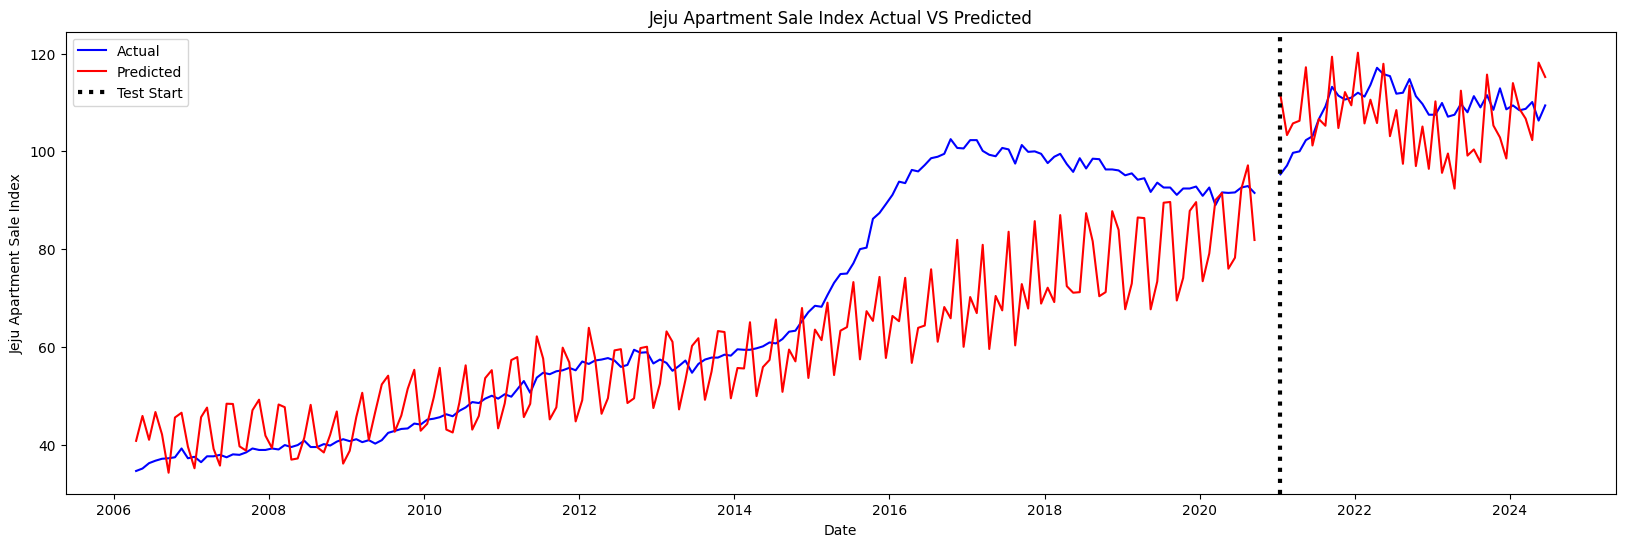

In [89]:
for i in range(len(target_column)):
    target_name = target_column[i] # Seoul

    # Prepare Dataset
    train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, target_name)
    columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", 
                  "residential_building_start_status"] + [target_name]
    train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, target_name, columns_to_use)
    test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, target_name, columns_to_use)
    # Prepare DataLoader 
    train_ds = Data(train_x, train_y)
    test_ds = Data(test_x, test_y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)
    
    # Train the model 
    train_loss_list = [] # save the train loss
    test_loss_list = [] # save the test loss

    # Define the model
    DLinear_model = DLinear(configs=configs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
    max_loss = 999999999

    patience_counter = 0

    for epoch in tqdm(range(1, epoch+1)):
        loss_list = []
        DLinear_model.train()
        train_loss = 0.0 
        for batch_idx, (data, target) in enumerate(train_dl):
            optimizer.zero_grad()
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        train_loss = np.mean(loss_list) 
        train_loss_list.append(train_loss) 

        DLinear_model.eval()
        with torch.no_grad():
            test_loss_list_epoch = []
            for data, target in test_dl:
                output = DLinear_model(data)
                test_loss = criterion(output, target.unsqueeze(-1))
                test_loss_list_epoch.append(test_loss.item())
            
            test_loss = np.mean(test_loss_list_epoch)
            test_loss_list.append(test_loss)
        
        if train_loss < max_loss:
            torch.save(DLinear_model.state_dict(), f"./DLinear_{version}_{target_name}.pth")
            max_loss = train_loss
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = train_loss
            dlinear_best_test_loss = test_loss
        else:
            patience_counter += 1
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
        
    ### Plot Loss Result ###
    fig, ax1 = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(train_loss_list) + 1)
    ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel("Train Loss",color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc="upper left")
    # ax1.grid()
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel("Test Loss",color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right") 
    # ax2.grid()
    plt.title('Train and Test Loss Over Epochs')
    fig.tight_layout()
    plt.show()
    
    # Load model and Evaluate
    DLinear_model.load_state_dict(torch.load(f"./DLinear_{version}_{target_name}.pth"))  # 최적 모델 로드
    DLinear_model.eval()
    te_dates, test_predictions, test_targets = predict(DLinear_model, test_dl, test_date, std_, mean_)
    tr_dates, train_predictions, train_targets = predict(DLinear_model, train_dl, train_date, std_, mean_)
    
    # Calculate the prediction performance of test dataset
    real = test_targets
    pred = test_predictions
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target_name,rmse,r2,DS]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False) # save to file
    
    # common factors 
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = f*100/f[142]
    
    ### Plot Prediction Result ###
    plt.figure(figsize=(20,6))
    plt.title(f"{target_name} Apartment Sale Index Actual VS Predicted")
   
    # Add Predicted Common Factors and Predicted Individuals
    plt.plot(pd.DataFrame(f.values, index=pd.to_datetime(f.index)) + 
             pd.concat([pd.DataFrame(train_targets, index=tr_dates),
                        pd.DataFrame(test_targets, index=te_dates)]),
             c='b', label="Actual")
    plt.plot(pd.DataFrame(f.values, index=pd.to_datetime(f.index)) + 
             pd.concat([pd.DataFrame(train_predictions, index=tr_dates),
                        pd.DataFrame(test_predictions, index=te_dates)]),
             c='r', label="Predicted")
    plt.axvline(x=te_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.xlabel('Date')
    plt.ylabel(f"{target_name} Apartment Sale Index")
    plt.legend()
    plt.show()

### Train and Save model (Input V2)
* f"{target}"
* window_size = 3
* forecast_size= 3 

In [86]:
### Experiment Setting
version = "V2"
window_size = 3
forecast_size= 3 
epoch = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = [resid.columns[0]] 
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=True,
    enc_in= len(columns_to_use) # feature_size
)

100%|██████████| 500/500 [00:13<00:00, 37.60it/s]


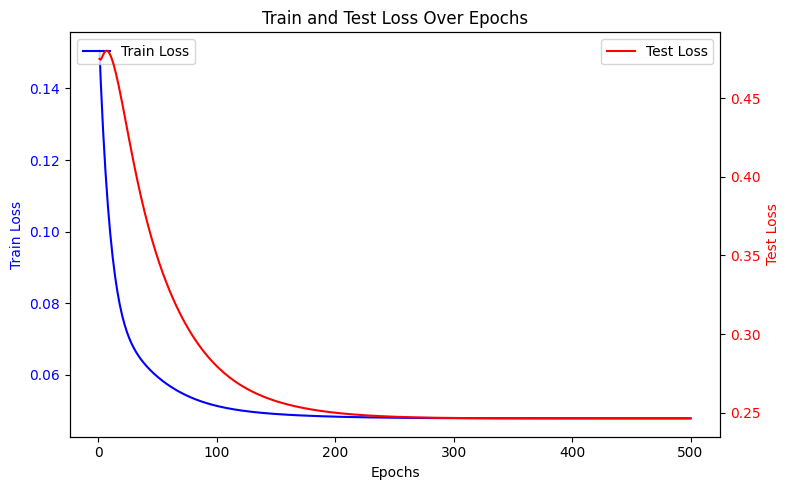

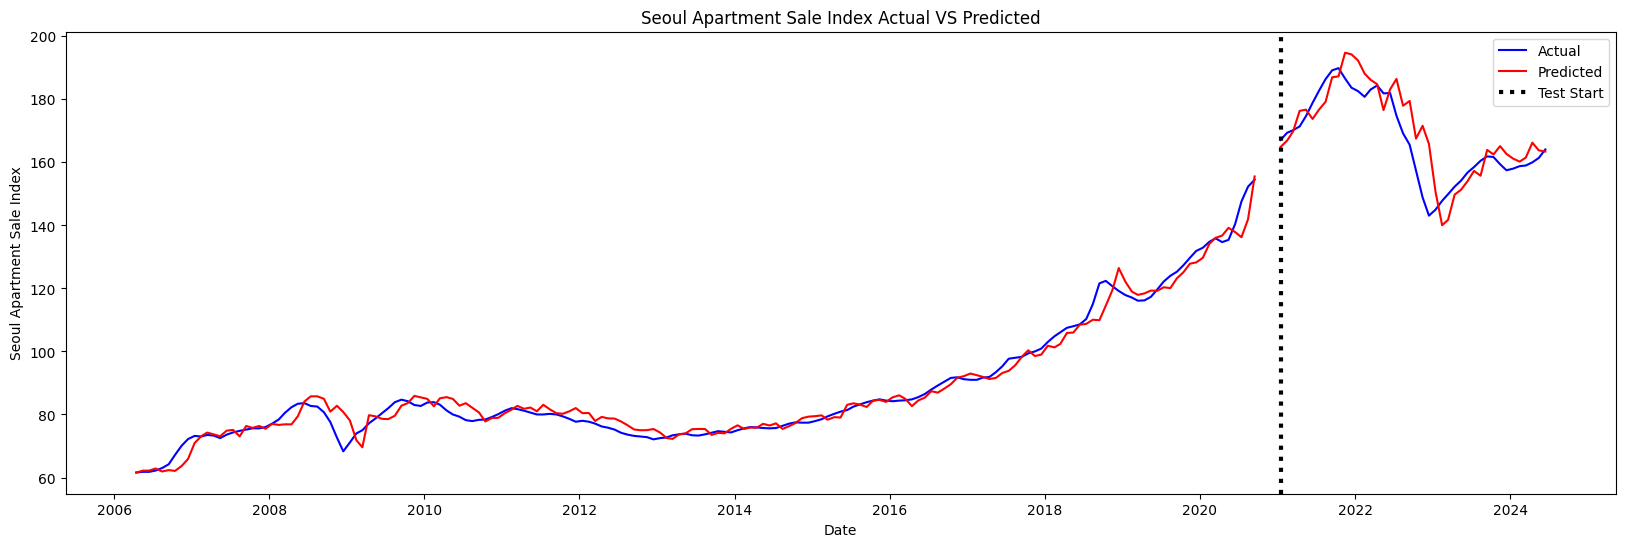

 84%|████████▍ | 420/500 [00:09<00:01, 44.12it/s]


Early stopping triggered.


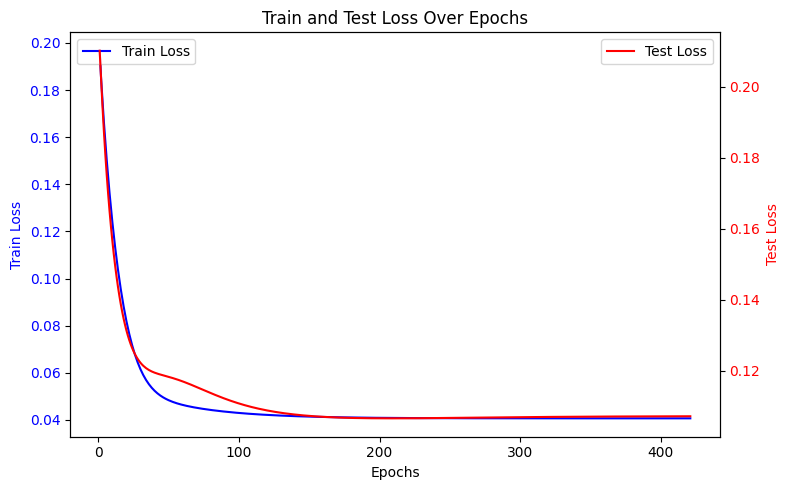

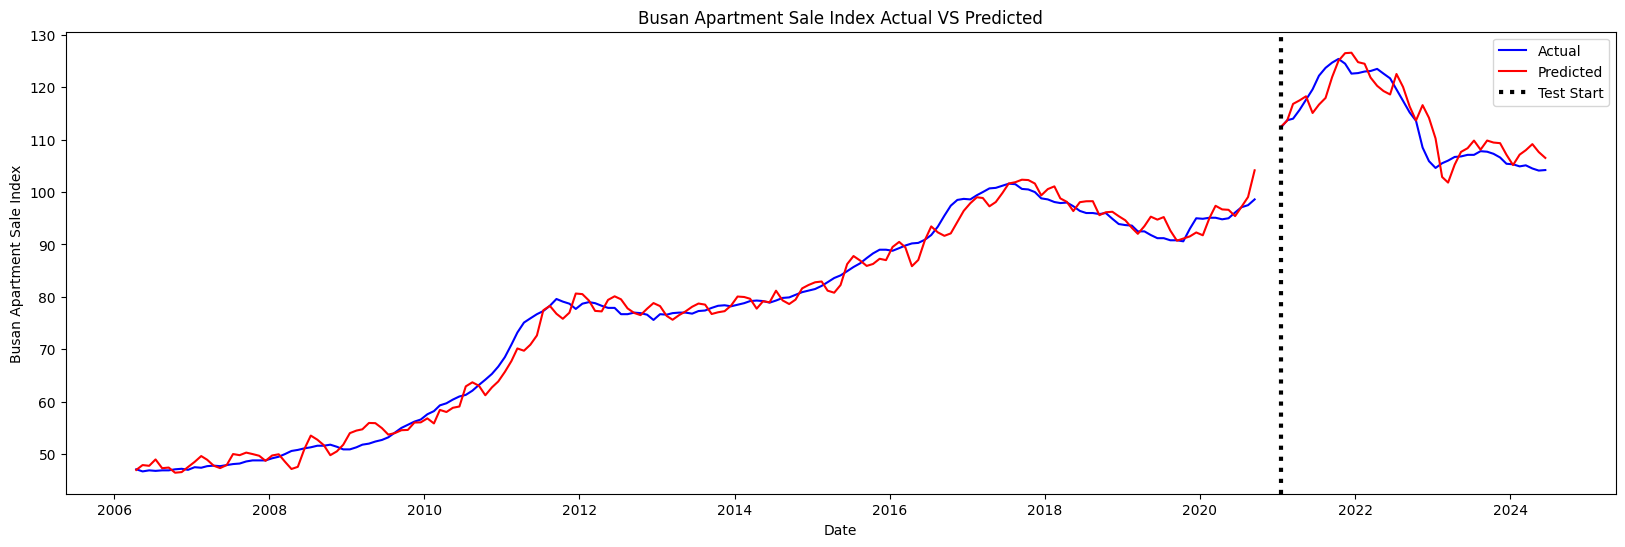

 90%|█████████ | 379/421 [00:08<00:00, 44.21it/s]


Early stopping triggered.


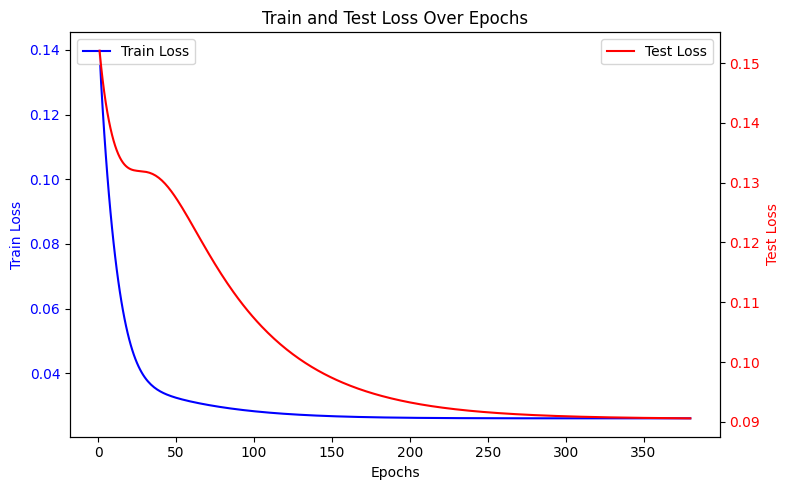

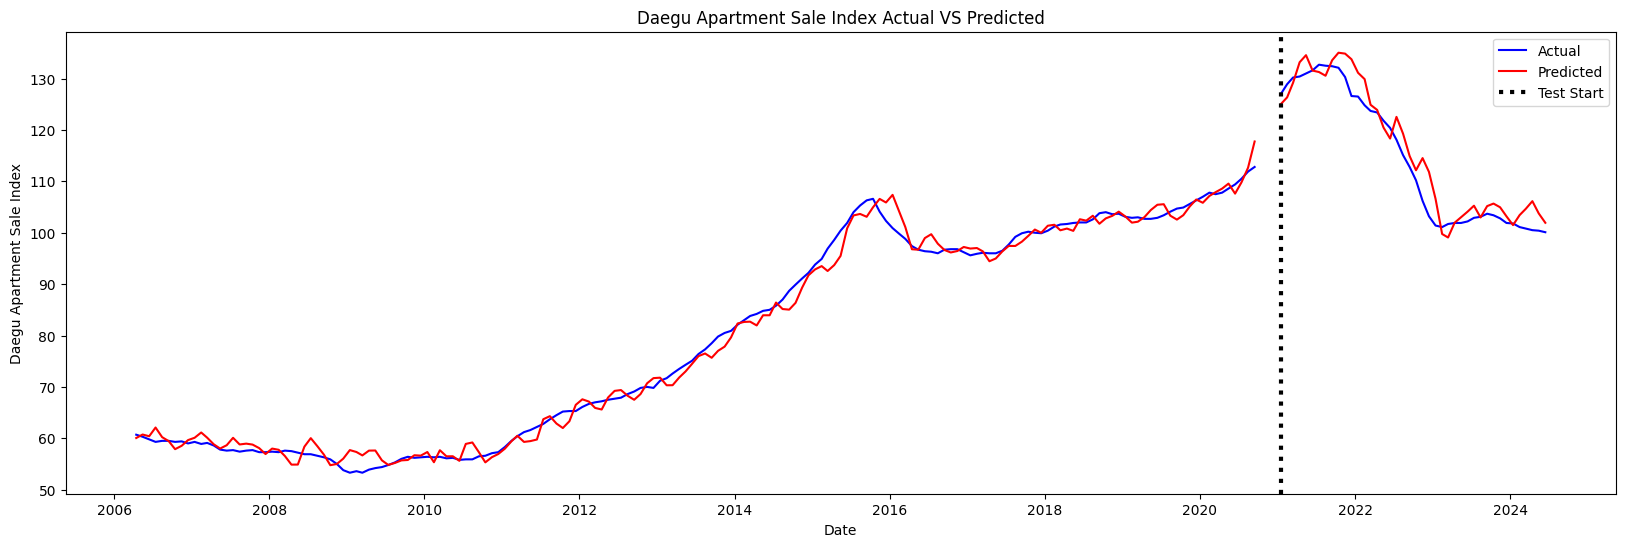

100%|██████████| 380/380 [00:08<00:00, 43.82it/s]


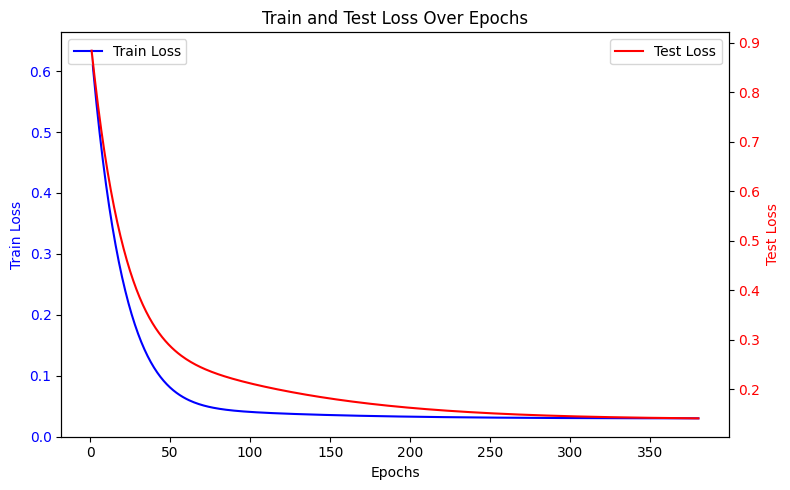

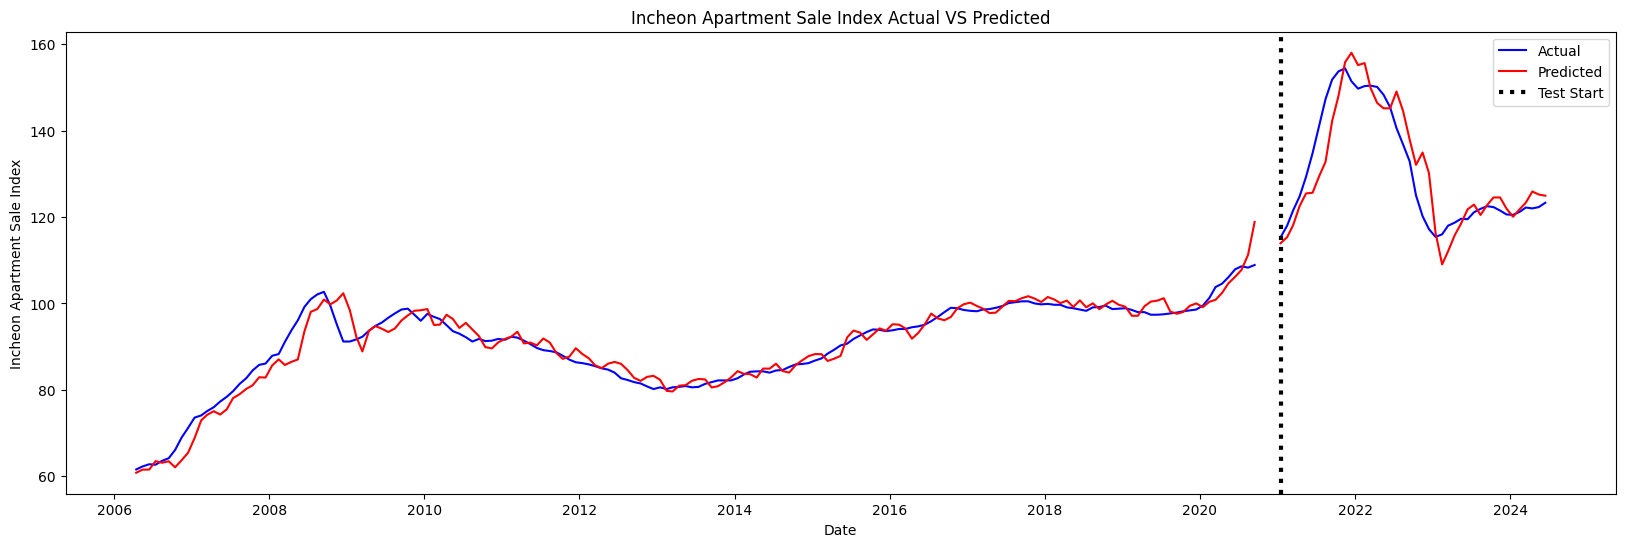

100%|██████████| 380/380 [00:11<00:00, 32.69it/s]


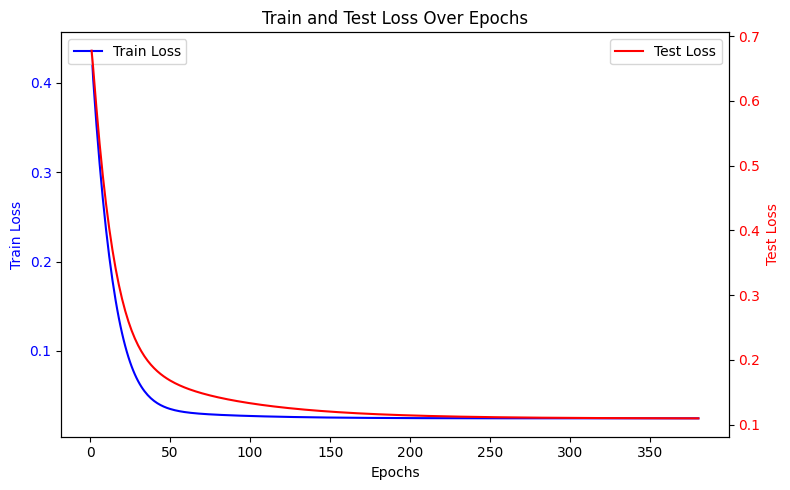

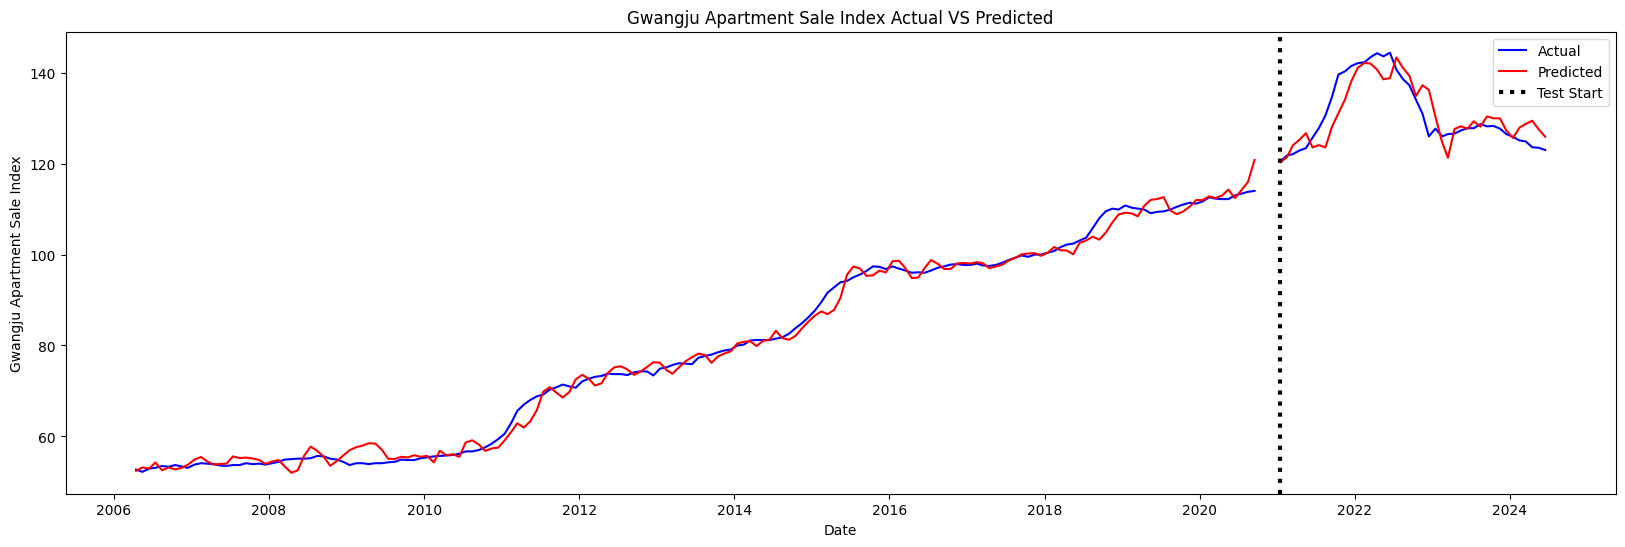

100%|██████████| 380/380 [00:09<00:00, 41.24it/s]


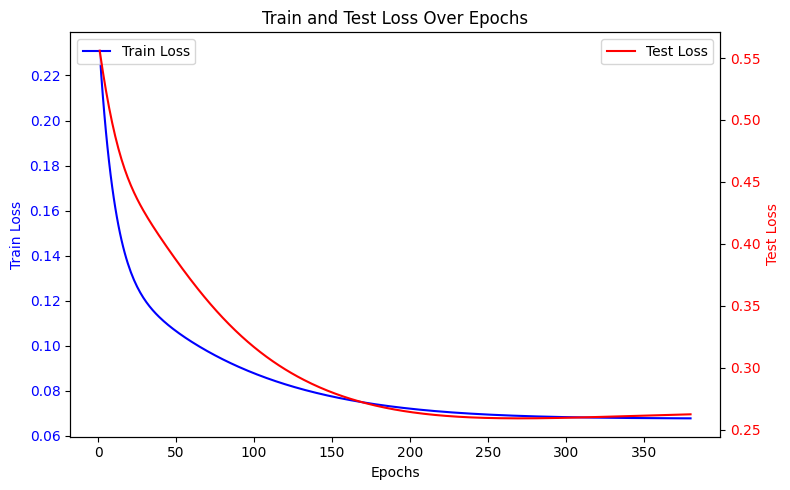

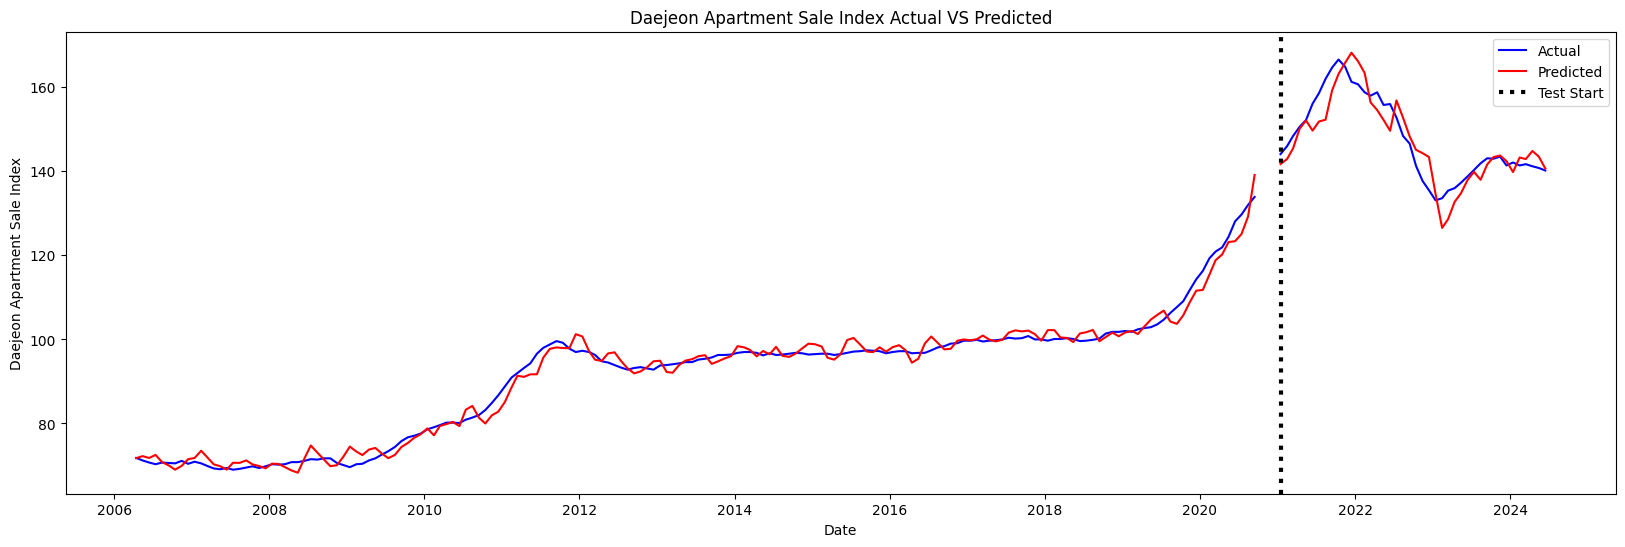

100%|█████████▉| 379/380 [00:07<00:00, 51.06it/s]


Early stopping triggered.


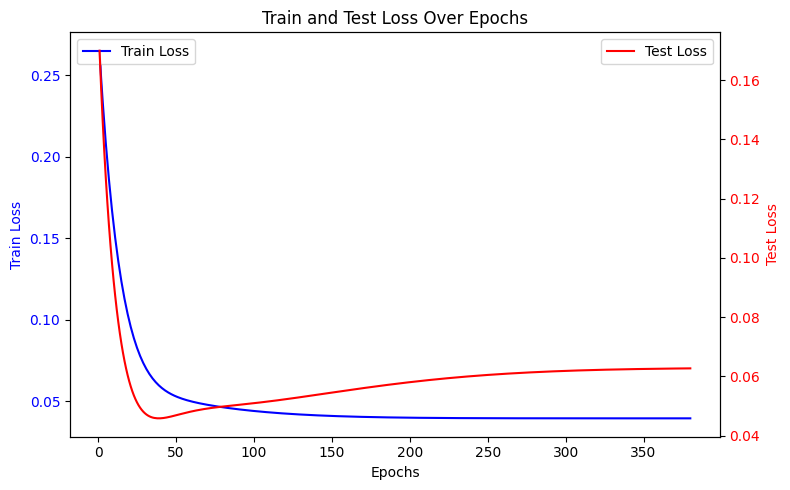

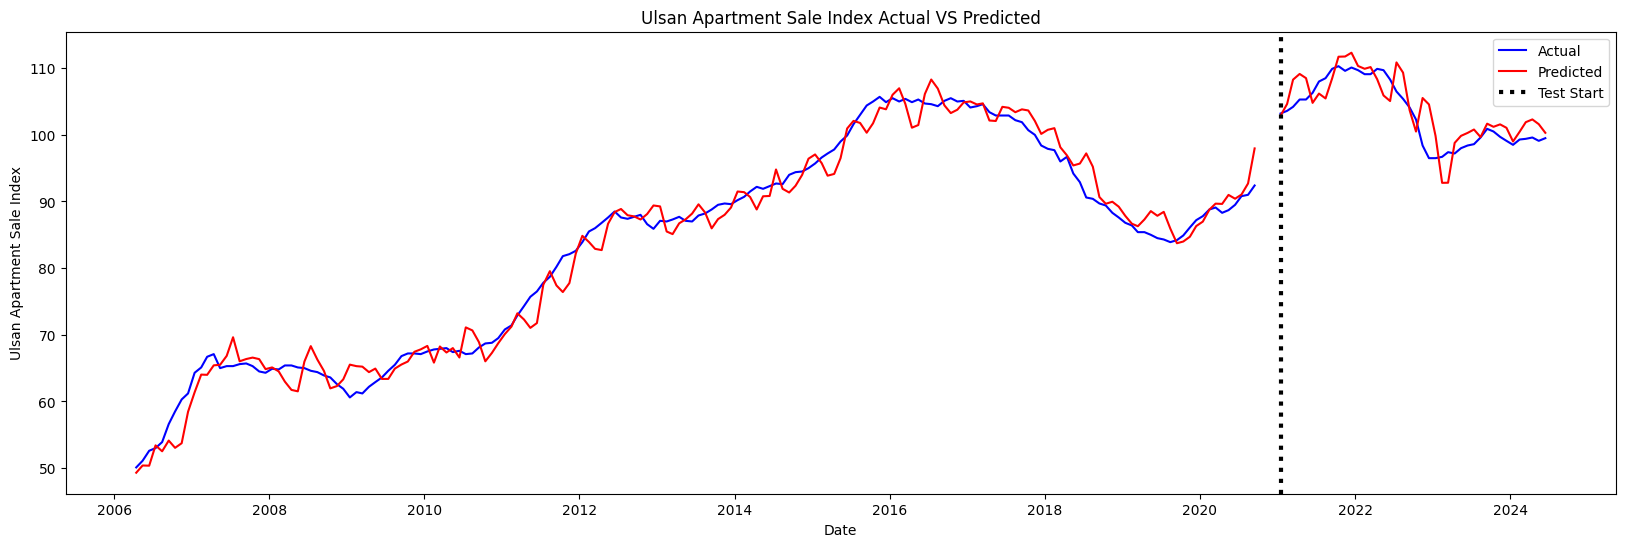

100%|██████████| 380/380 [00:07<00:00, 49.24it/s]


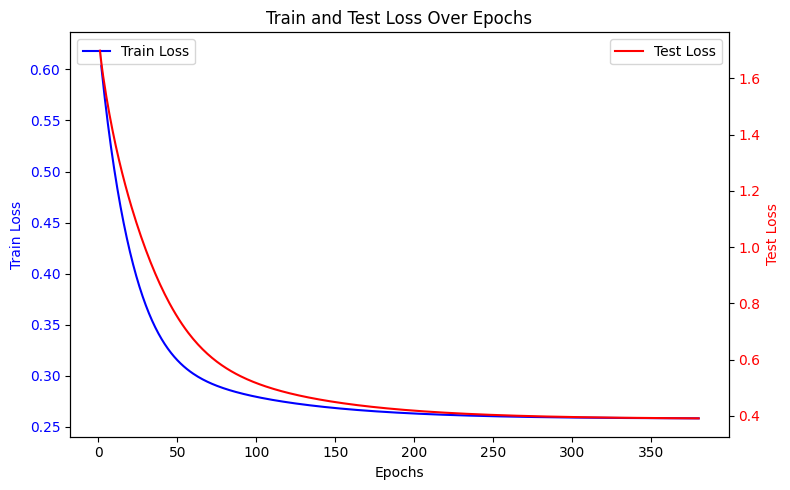

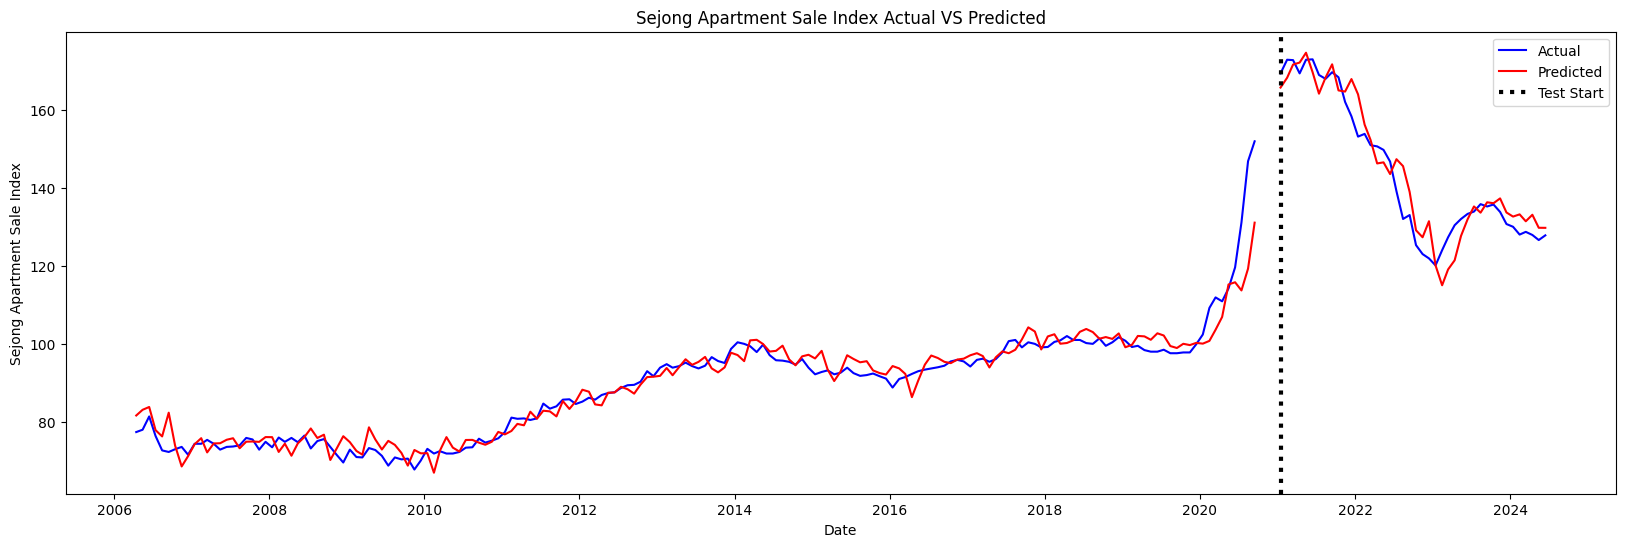

100%|██████████| 380/380 [00:07<00:00, 50.54it/s]


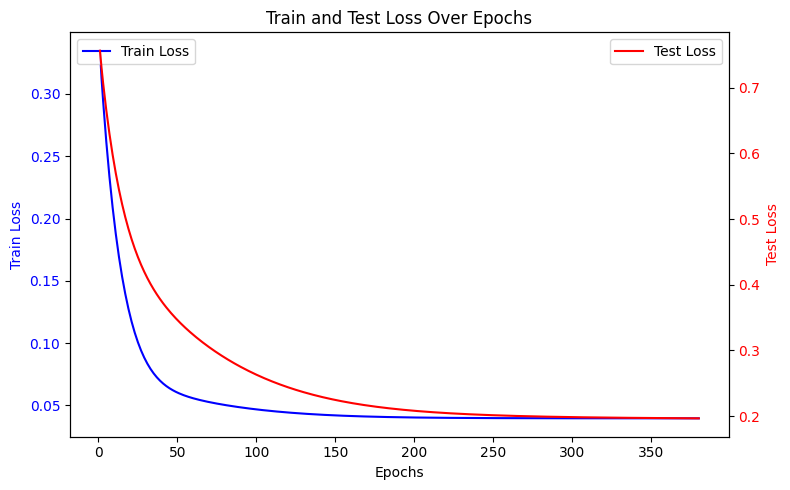

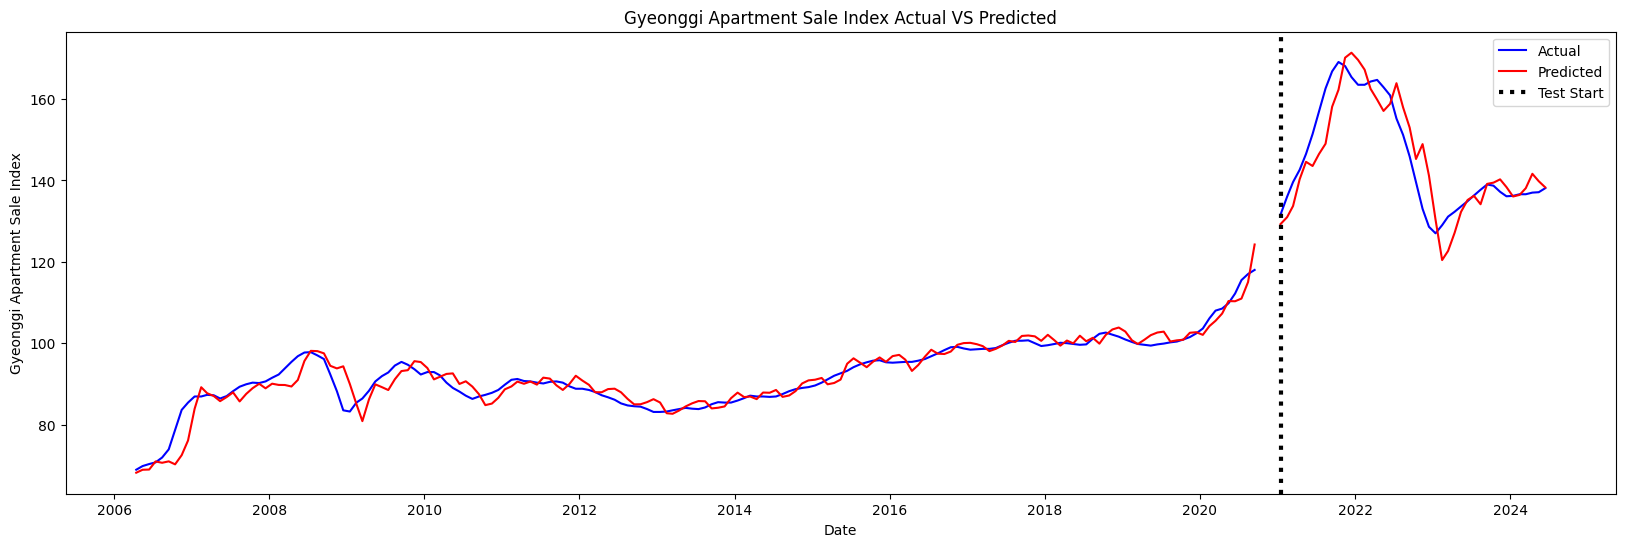

 90%|█████████ | 342/380 [00:07<00:00, 47.63it/s]


Early stopping triggered.


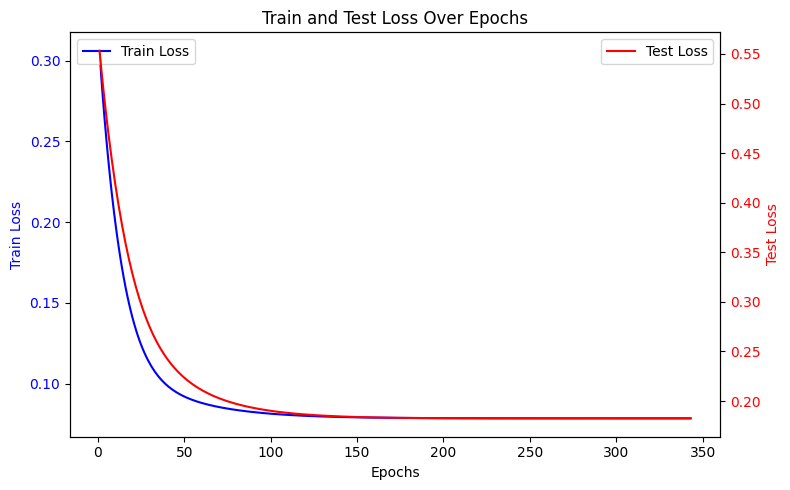

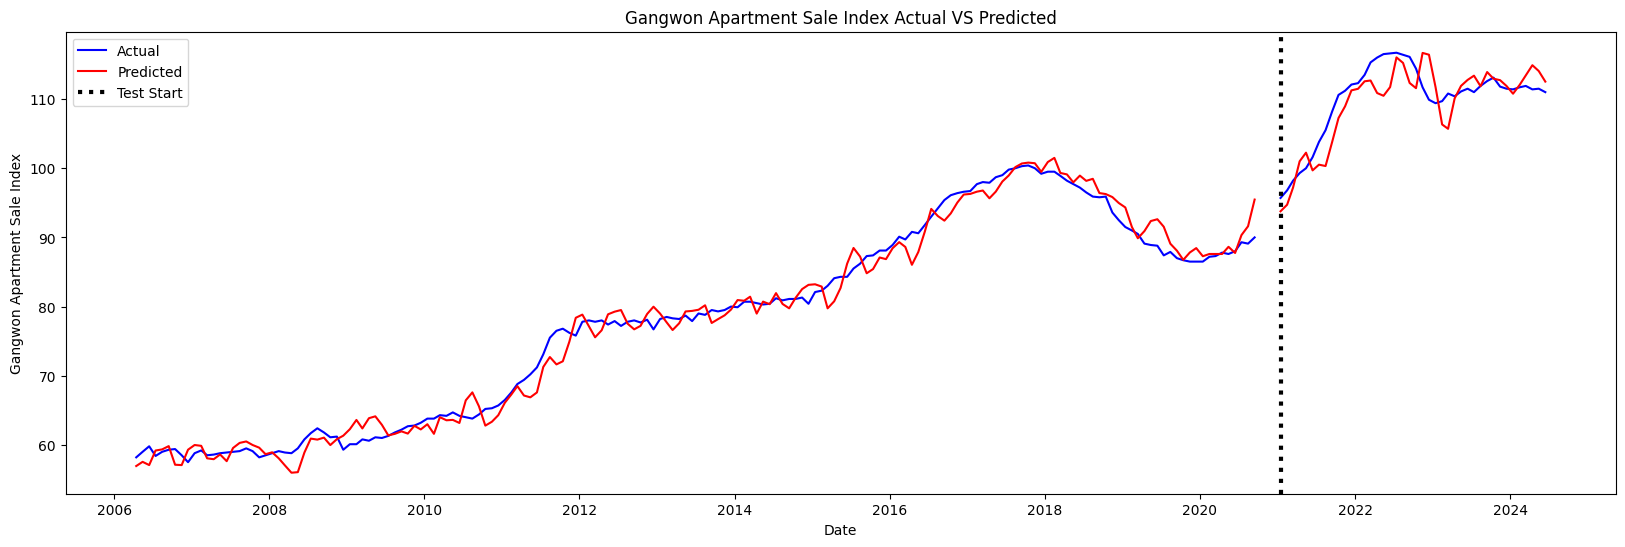

 85%|████████▌ | 293/343 [00:05<00:01, 48.90it/s]


Early stopping triggered.


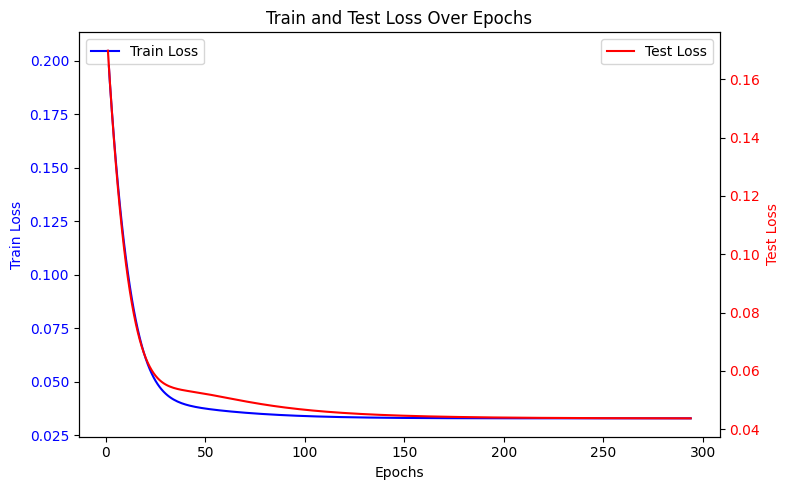

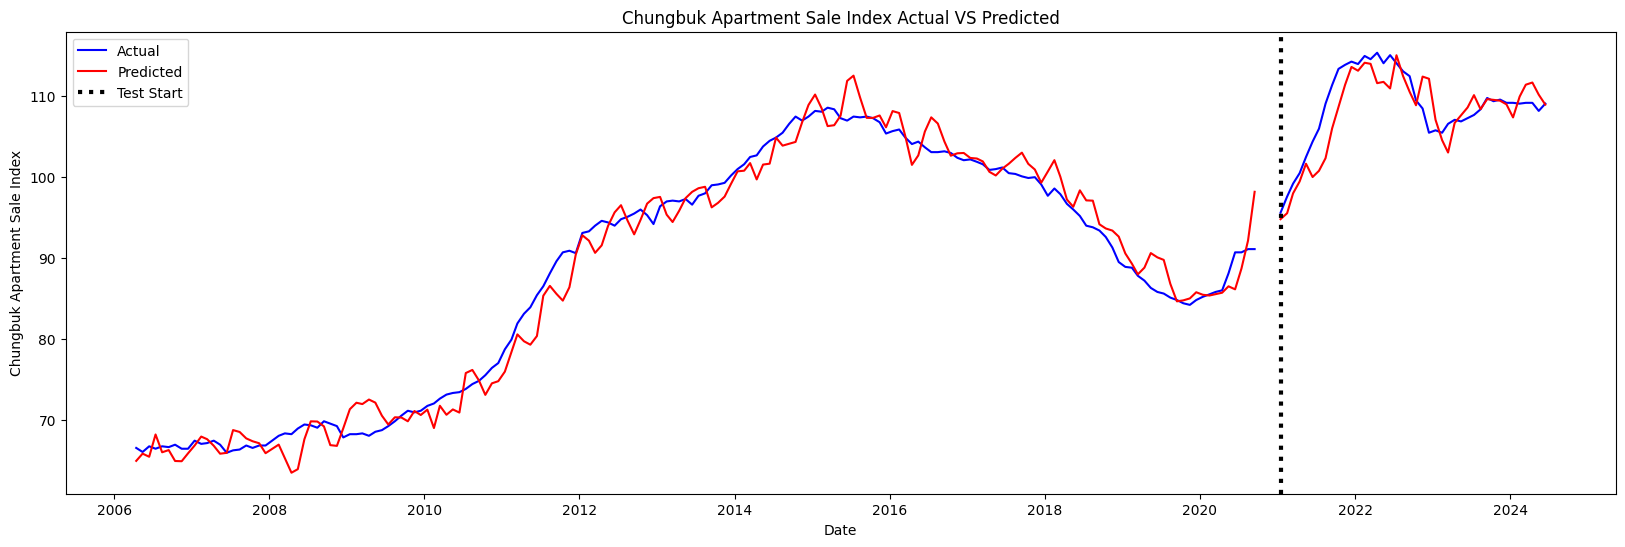

100%|██████████| 294/294 [00:06<00:00, 47.36it/s]


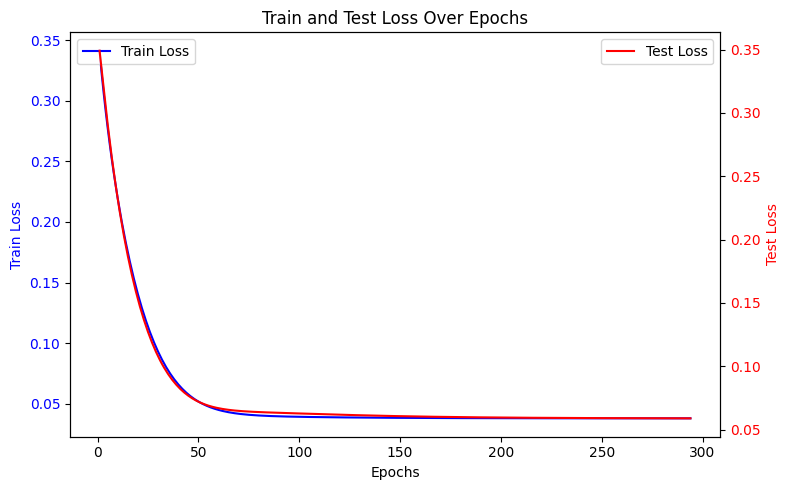

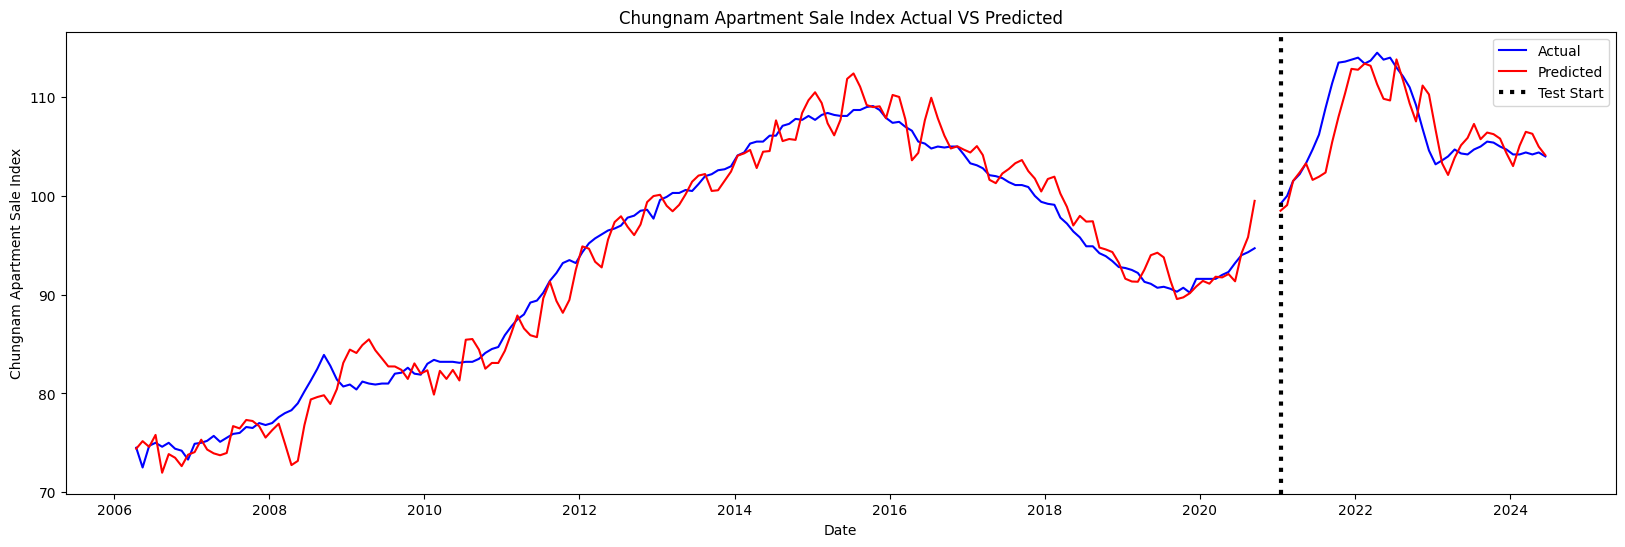

100%|██████████| 294/294 [00:06<00:00, 48.04it/s]


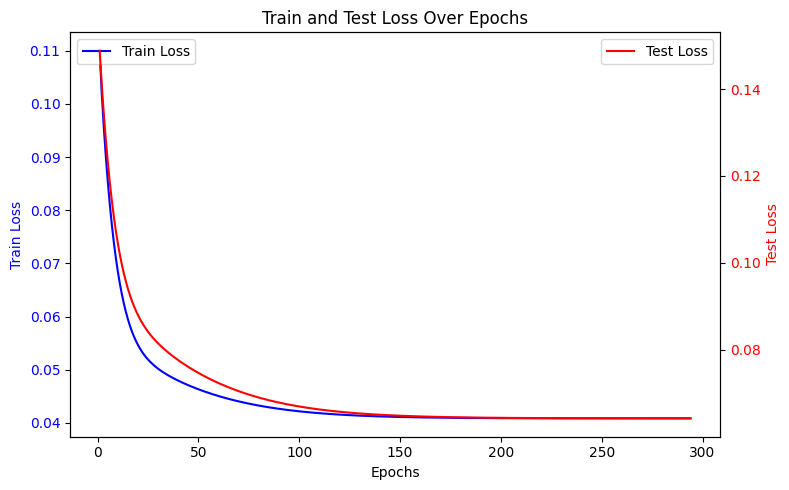

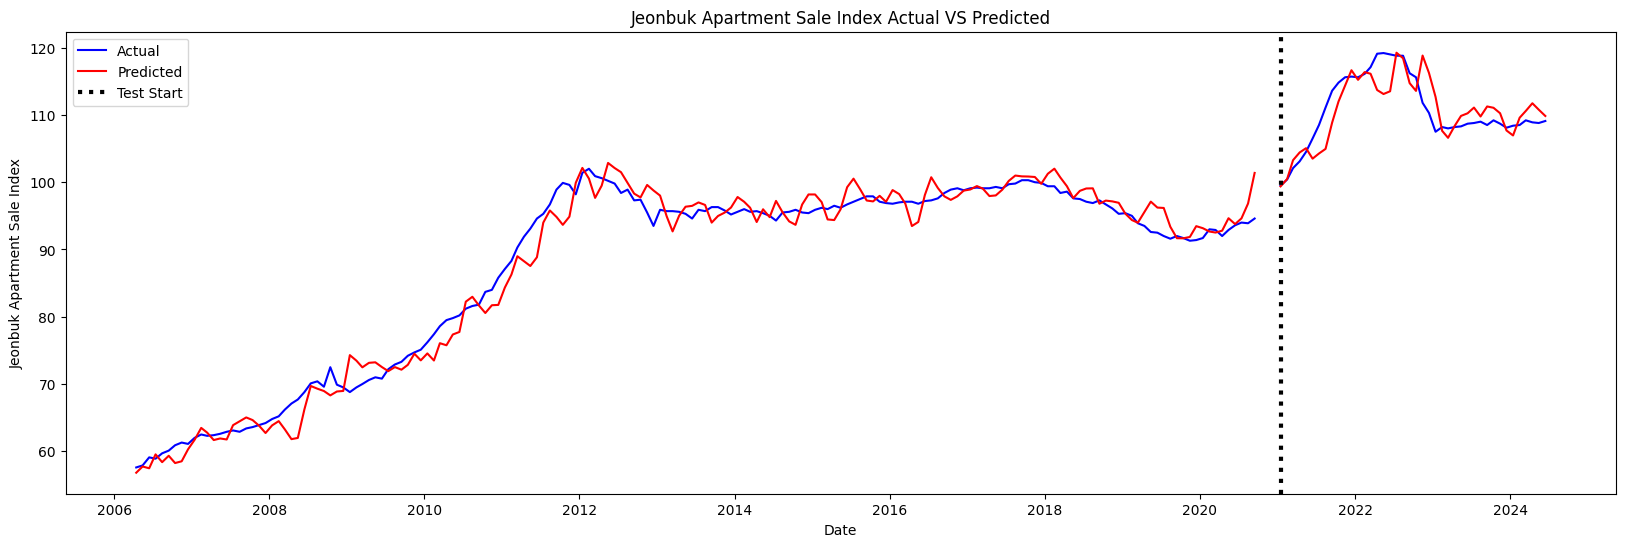

 89%|████████▉ | 261/294 [00:06<00:00, 38.96it/s]


Early stopping triggered.


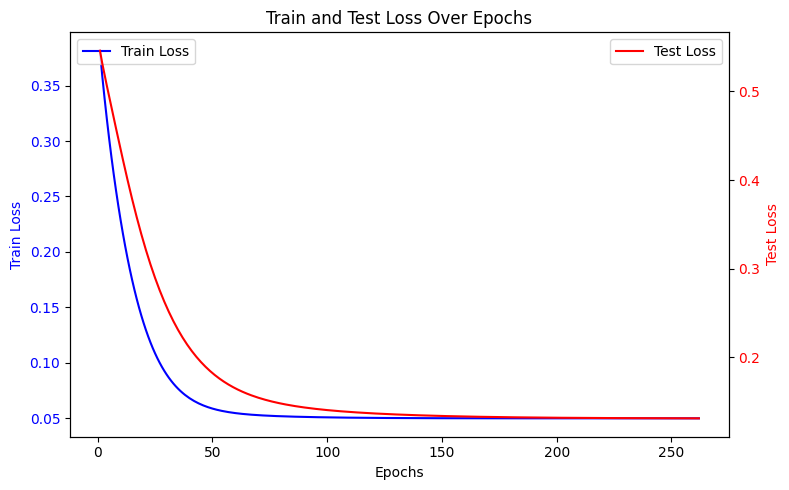

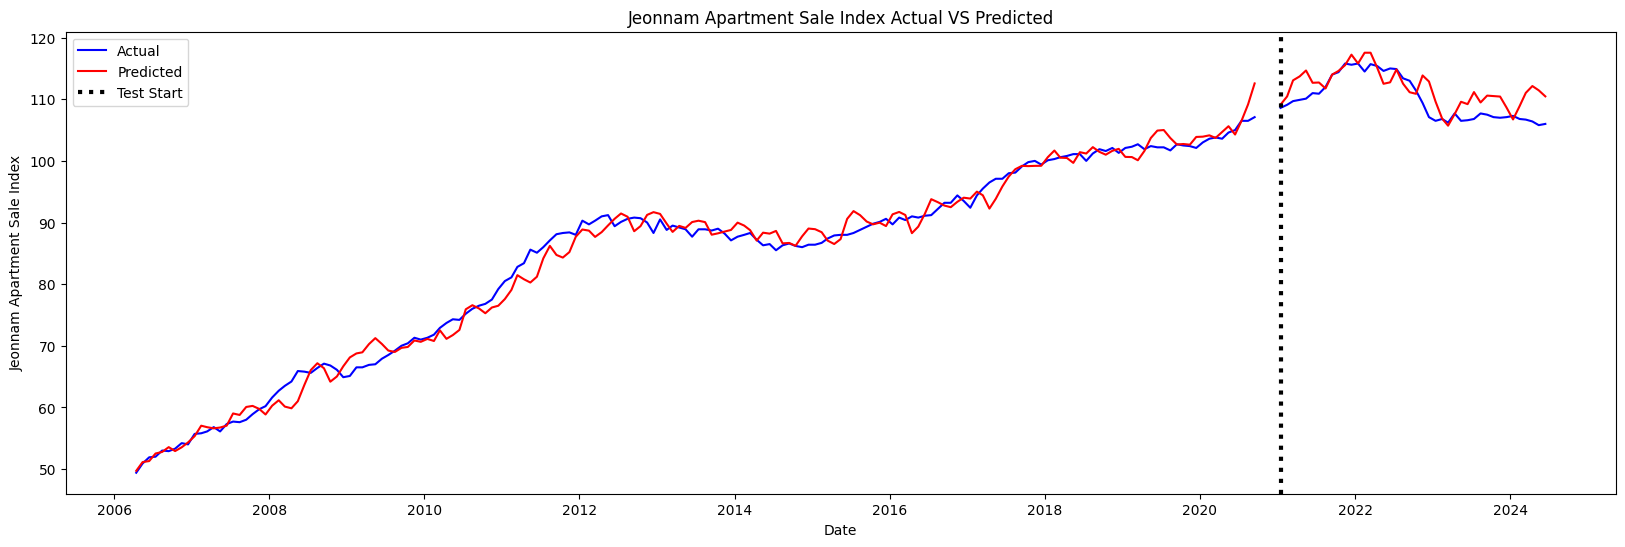

100%|██████████| 262/262 [00:07<00:00, 36.84it/s]


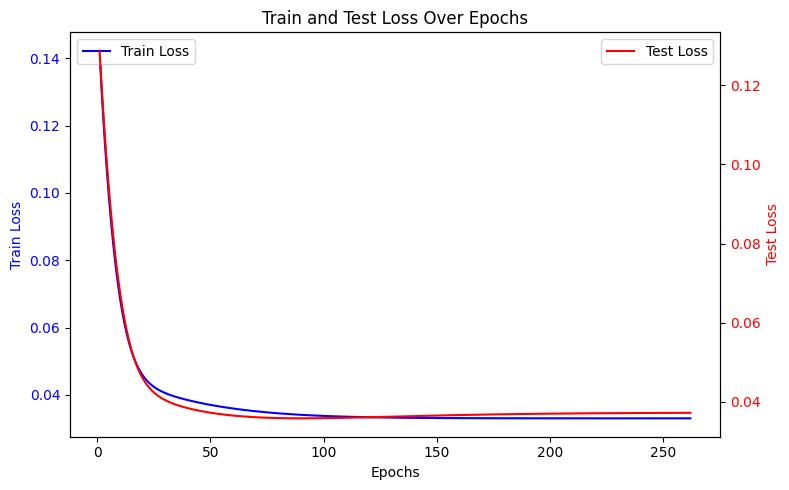

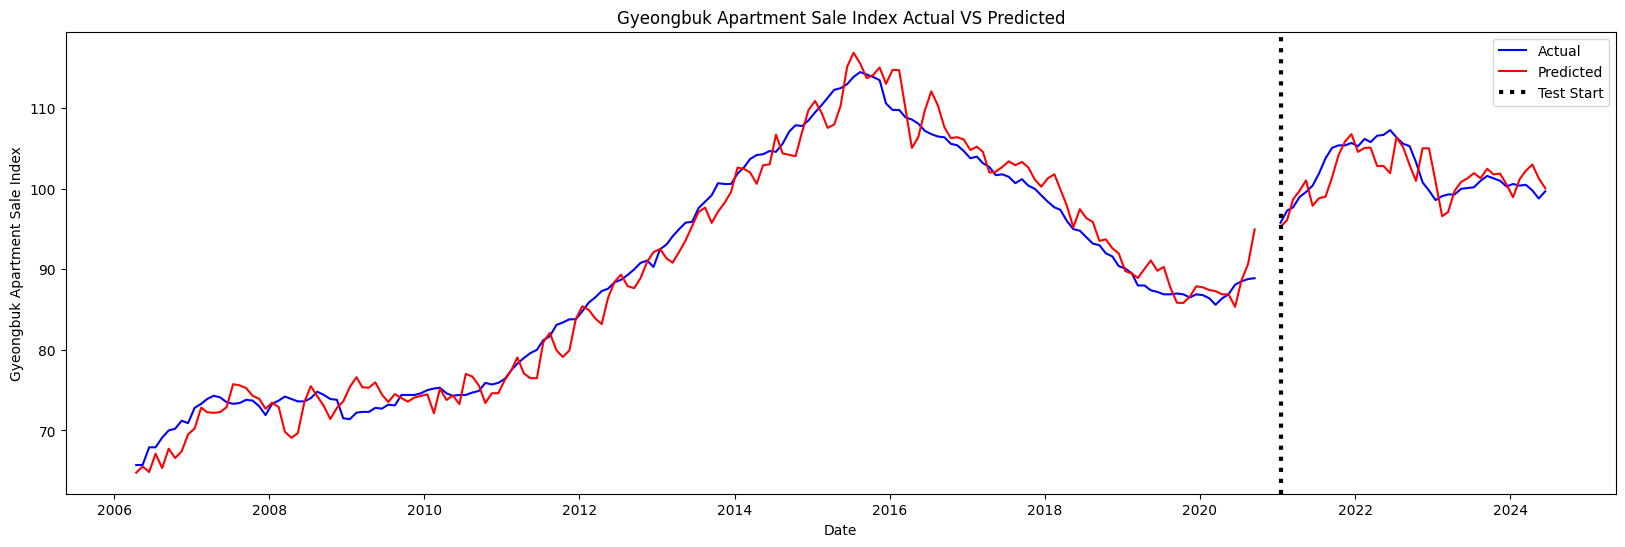

100%|██████████| 262/262 [00:08<00:00, 32.44it/s]


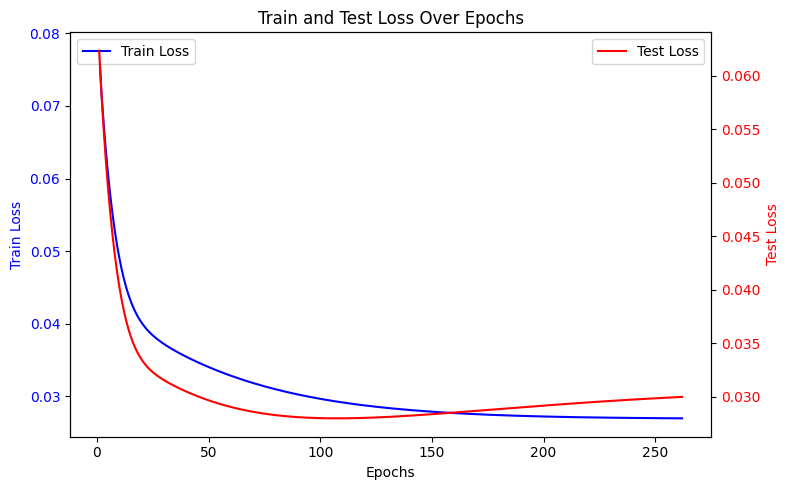

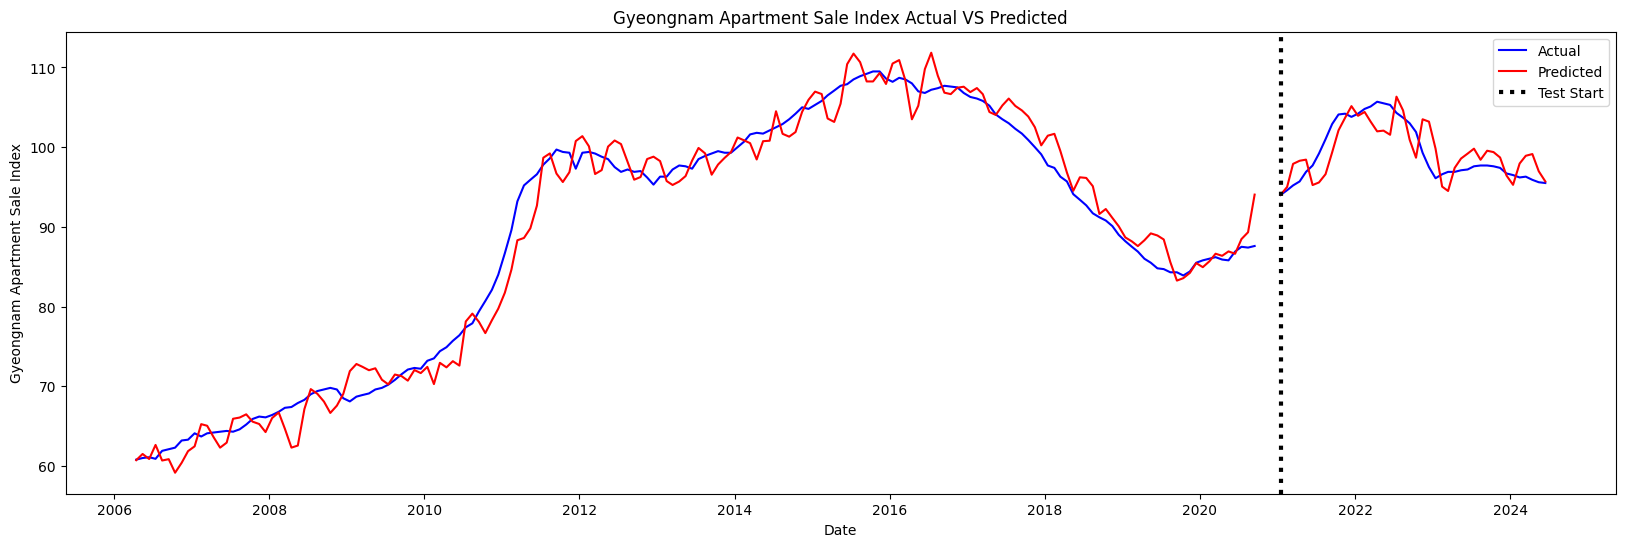

100%|██████████| 262/262 [00:05<00:00, 44.69it/s]


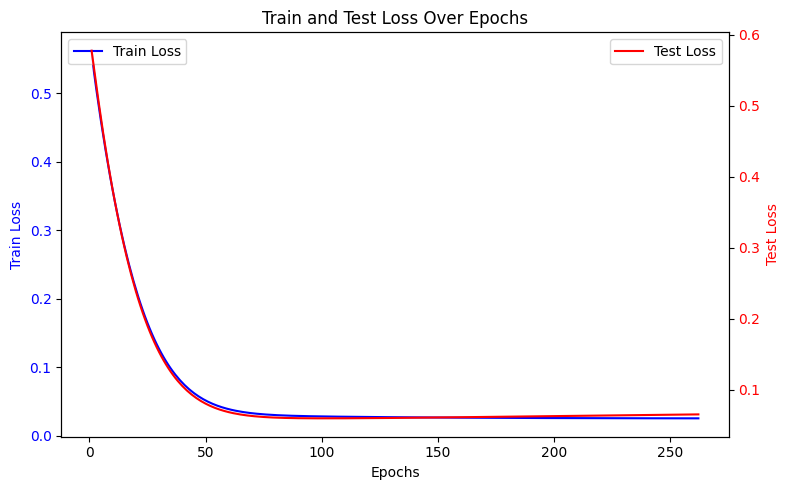

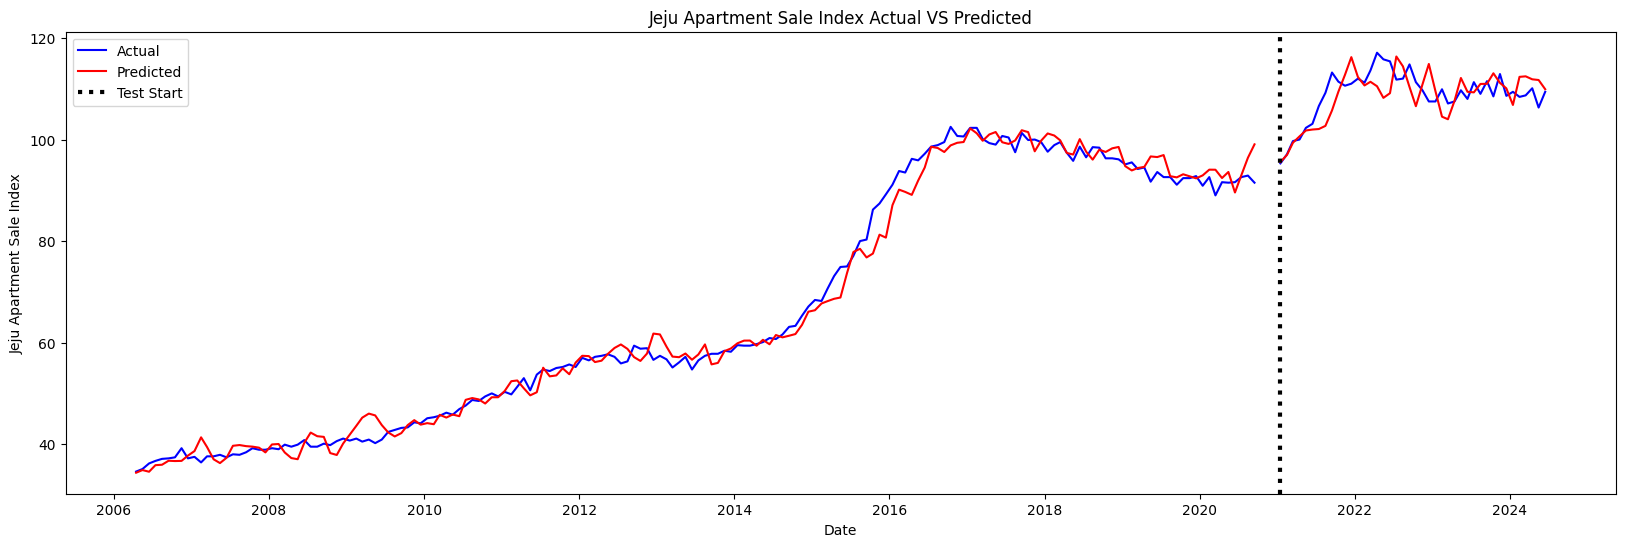

In [87]:
for i in range(len(target_column)):
    target_name = target_column[i] # Seoul

    # Prepare Dataset
    train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, target_name)
    columns_to_use = [target_name]
    train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, target_name, columns_to_use)
    test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, target_name, columns_to_use)
    # Prepare DataLoader 
    train_ds = Data(train_x, train_y)
    test_ds = Data(test_x, test_y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)
    
    # Train the model 
    train_loss_list = [] # save the train loss
    test_loss_list = [] # save the test loss

    # Define the model
    DLinear_model = DLinear(configs=configs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
    max_loss = 999999999

    patience_counter = 0

    for epoch in tqdm(range(1, epoch+1)):
        loss_list = []
        DLinear_model.train()
        train_loss = 0.0 
        for batch_idx, (data, target) in enumerate(train_dl):
            optimizer.zero_grad()
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        train_loss = np.mean(loss_list) 
        train_loss_list.append(train_loss) 

        DLinear_model.eval()
        with torch.no_grad():
            test_loss_list_epoch = []
            for data, target in test_dl:
                output = DLinear_model(data)
                test_loss = criterion(output, target.unsqueeze(-1))
                test_loss_list_epoch.append(test_loss.item())
            
            test_loss = np.mean(test_loss_list_epoch)
            test_loss_list.append(test_loss)
        
        if train_loss < max_loss:
            torch.save(DLinear_model.state_dict(), f"./DLinear_{version}_{target_name}.pth")
            max_loss = train_loss
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = train_loss
            dlinear_best_test_loss = test_loss
        else:
            patience_counter += 1
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
        
    ### Plot Loss Result ###
    fig, ax1 = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(train_loss_list) + 1)
    ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel("Train Loss",color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc="upper left")
    # ax1.grid()
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel("Test Loss",color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right") 
    # ax2.grid()
    plt.title('Train and Test Loss Over Epochs')
    fig.tight_layout()
    plt.show()
    
    # Load model and Evaluate
    DLinear_model.load_state_dict(torch.load(f"./DLinear_{version}_{target_name}.pth"))  # 최적 모델 로드
    DLinear_model.eval()
    te_dates, test_predictions, test_targets = predict(DLinear_model, test_dl, test_date, std_, mean_)
    tr_dates, train_predictions, train_targets = predict(DLinear_model, train_dl, train_date, std_, mean_)
    
    # Calculate the prediction performance of test dataset
    real = test_targets
    pred = test_predictions
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target_name,rmse,r2,DS]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False) # save to file
    
    # common factors 
    f = factor1_df * fa.loadings_[i][0] + factor2_df * fa.loadings_[i][1]
    f = f*100/f[142]
    
    ### Plot Prediction Result ###
    plt.figure(figsize=(20,6))
    plt.title(f"{target_name} Apartment Sale Index Actual VS Predicted")
   
    # Add Predicted Common Factors and Predicted Individuals
    plt.plot(pd.DataFrame(f.values, index=pd.to_datetime(f.index)) + 
             pd.concat([pd.DataFrame(train_targets, index=tr_dates),
                        pd.DataFrame(test_targets, index=te_dates)]),
             c='b', label="Actual")
    plt.plot(pd.DataFrame(f.values, index=pd.to_datetime(f.index)) + 
             pd.concat([pd.DataFrame(train_predictions, index=tr_dates),
                        pd.DataFrame(test_predictions, index=te_dates)]),
             c='r', label="Predicted")
    plt.axvline(x=te_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.xlabel('Date')
    plt.ylabel(f"{target_name} Apartment Sale Index")
    plt.legend()
    plt.show()